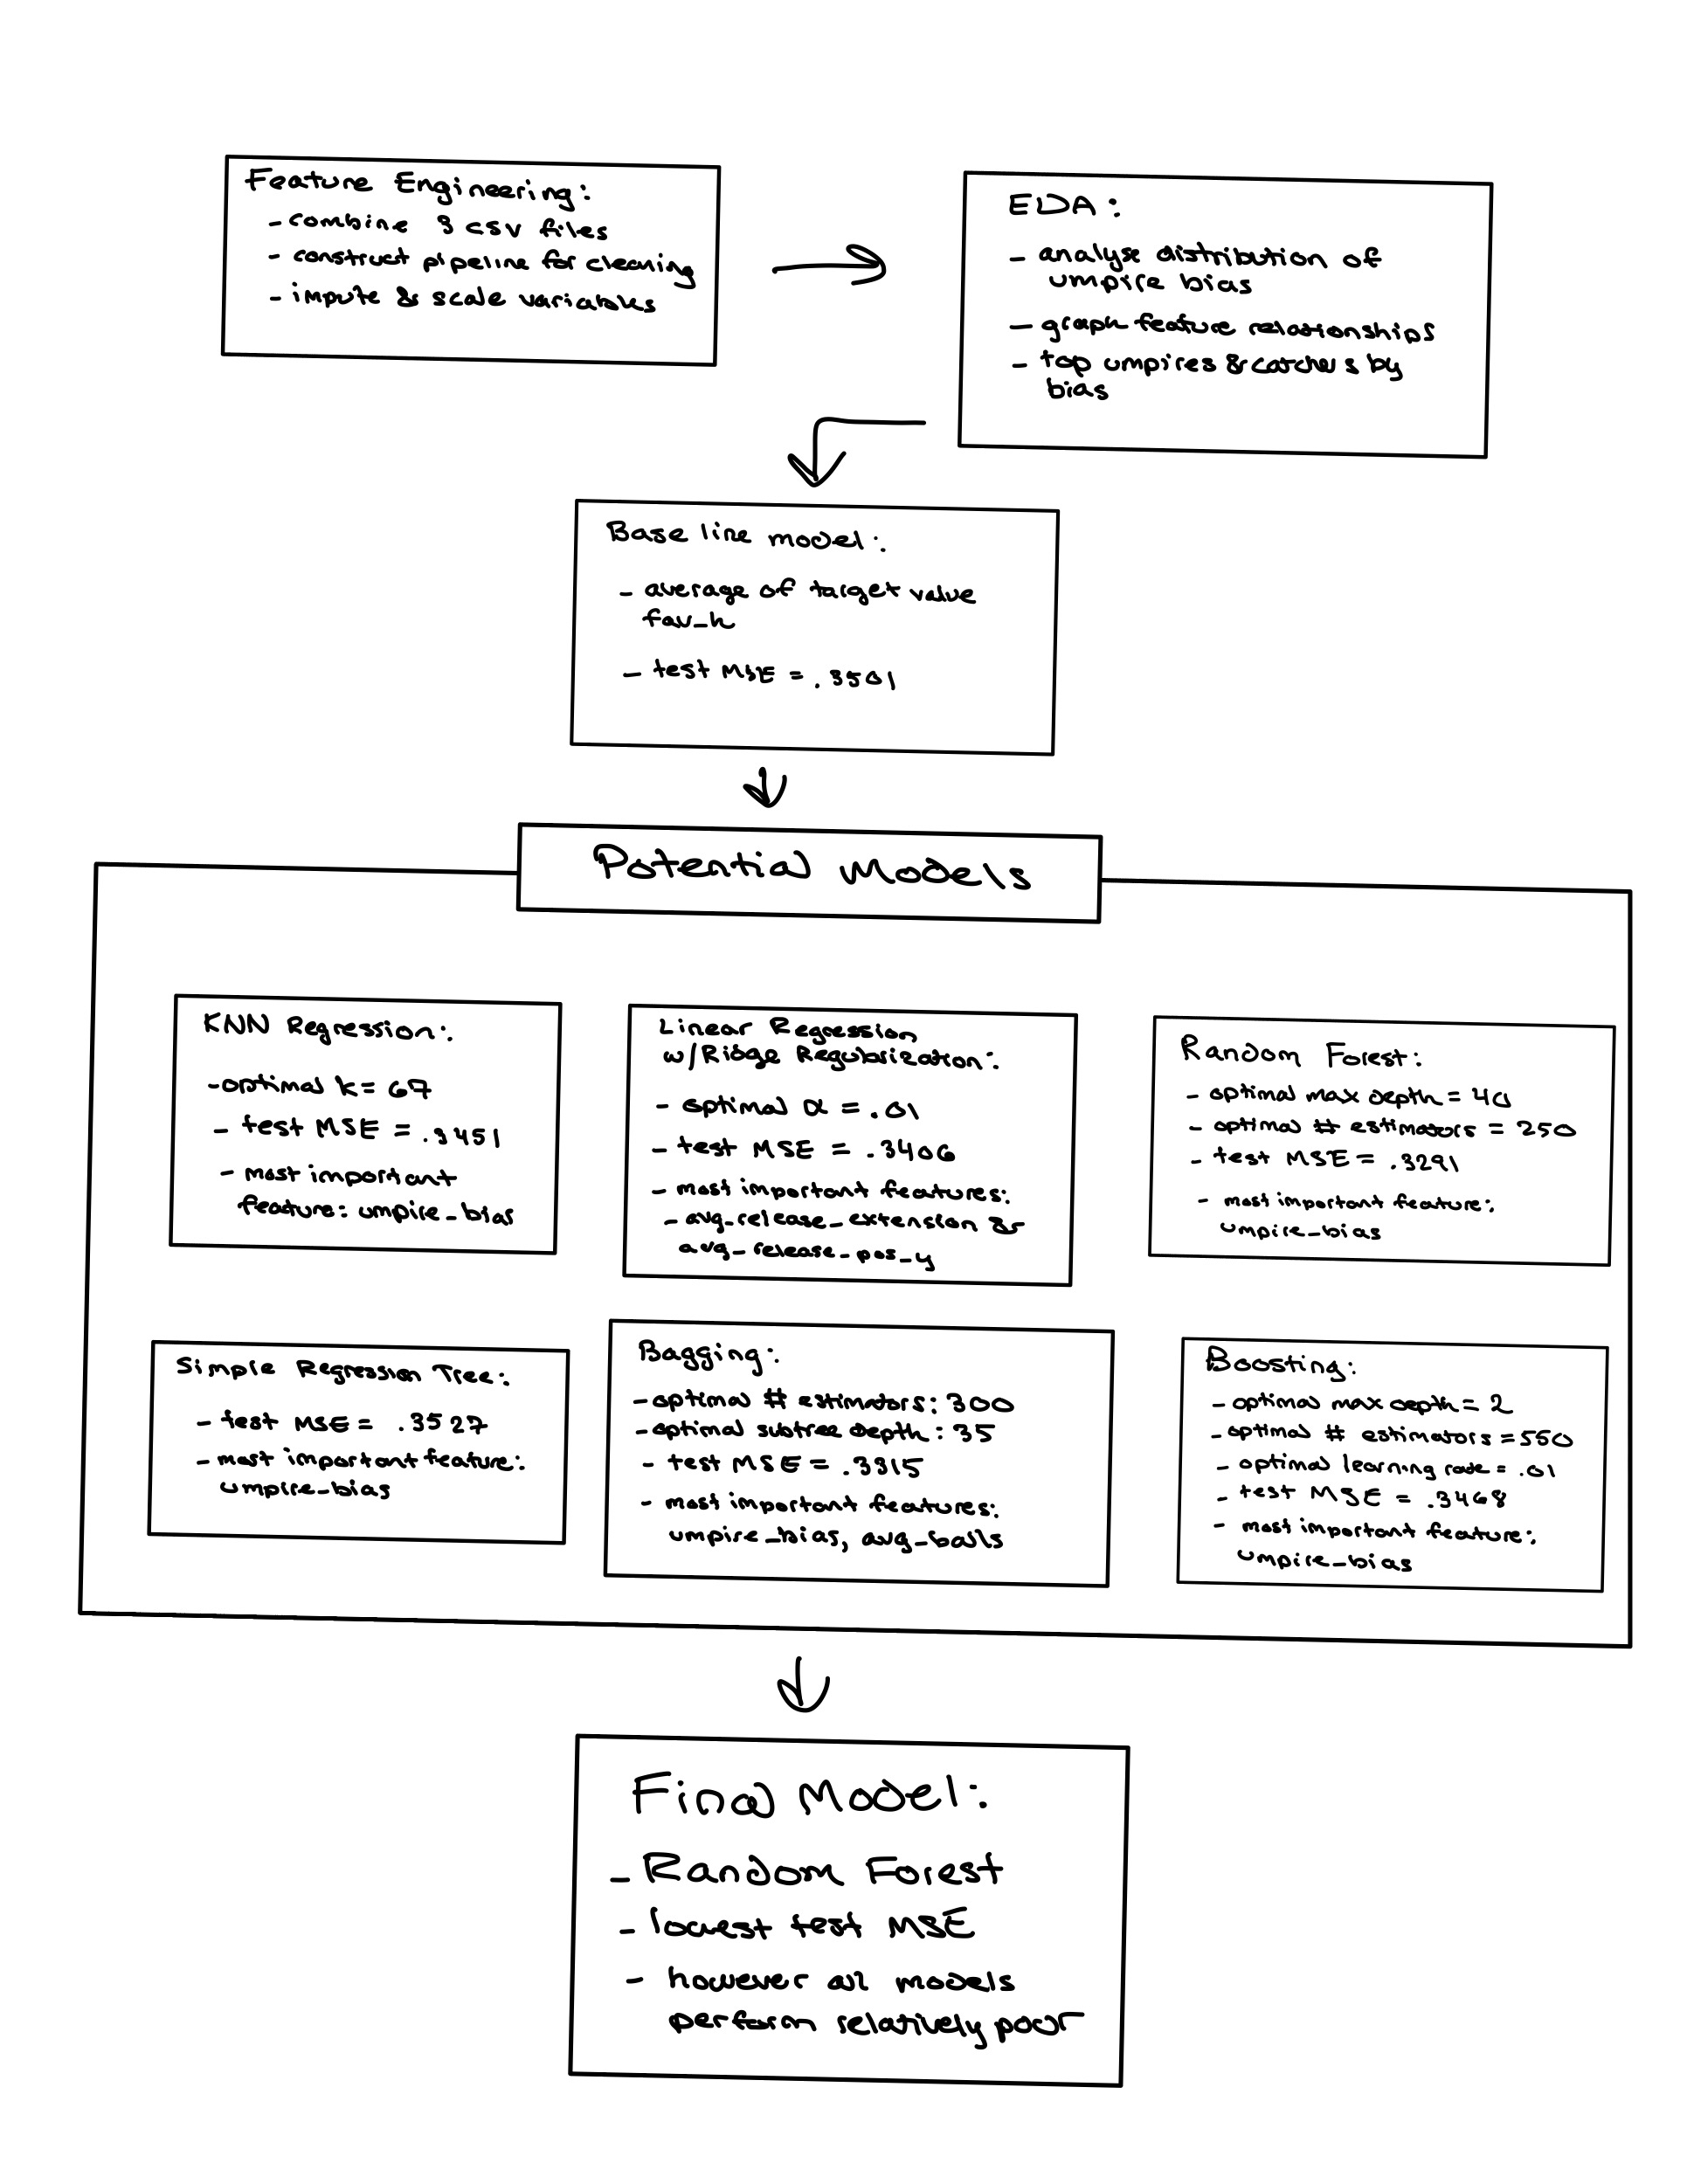

In [ ]:
image_path = 'path.jpg'
display(Image(filename=image_path))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from IPython.display import Image


# for statcast integration
!pip install pybaseball --quiet
from pybaseball import statcast
import pandas as pd
import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 25.3 MB/s eta 0:00:00


# Table of Contents

1. [Problem Statement and Research Questions](#problem-statement-and-research-question)
2. [Dataset and Feature Engineering](#dataset-and-feature-engineering)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
4. [Modeling](#modeling)
  - Naive Model
  - KNN
  - Linear Regression with Ridge Regularization
  - Single Decision Tree
  - Bagging
  - Random Forest
  - Gradient Boosting
5. [Model Results and Conclusion](#model-results-and-interpretations)



# 1. Problem Statement and Research Question

**Motivation**
Our project focuses on predicting umpire bias/error in baseball

Every pitch in MLB game has a potential to shift game outcomes, so incorrect calls by umpires carry a lot of weight. We expect that these errors could be caused by personal bias/error, by the ability of a picture or catcher to frame a pitch and influence calls, or by high-pressure in game scenarios.

By merging umpire scorecards data which tracks incorrect calls, along with game, player, and even pitch level data from baseball reference, statcast and razzball, we were able to better research what factors effect umpire bias.

**Problem Statement**

In this project, we attempt to determine which factors (regarding the pitcher, catcher, and umpire) are most associated with umpire bias, and to develop a regression model which can predict the scoring effect of incorrect calls in a game based on the pitcher, catcher, and umpire of that game.

**Research Questions**  

1) Based on pitcher, catcher, and umpire data, can we effectively predict the projected impact of umpire bias and pitch-framing in game outcomes?

2) Which factors have the biggest effect on umpire calls?


# 2. Dataset and Feature Engineering

## Overview of Original Data

The datasets we began with contain info about umpire bias (`fav_h`), catcher/pitcher performance (`strike_rate`), and other game details over the 2024 MLB season + postseason. The original set of features includes:

- `fav_h`: Bias toward the home team by the home-plate umpire (measured in run expectancy impact*)
- `game_date`: Game date
- `home_team`: Home team in a game
- `away_team`: Away team in a game
- `catcher_id`: Catcher unique ID
- `Name`: Catcher's name
- `MLBAMID`: Team ID for the team the catcher in the row plays for
- `team`: Team that the row's pitching-related features focus on
- `STD_POS`: Standard position played by the catcher listed in the row
- `strike_rate`: Percentage of pitches caught by the catcher that are strikes
- `umpire`: Home plate umpire's name


*Run expectancy impact refers to the change in the expected number of runs that are likely to be scored by a team in a given game. This value changes with each pitch and play in a game.


## Clean Up, Clean Up. Everybody, Everywhere!

### Synthesizing Datasets

We started with three distinct datasets
- **catcher_data.csv**, which contains profile data on each individual catcher such as name, team, and ID, across which we can merge and label datasets.
- **framing.csv**, which includes data on catchers' strike rate in the outer areas of the strike zone, in an attempt to explain their success in framing pitches at the edge of the strike zone.
- **games.csv**, which lists the umpire, teams, and Fav [H] effect by game.

We then cleaned and merged our datasets per the comments and code blocks below:

In [ ]:
# load games.csv
data = pd.read_csv('games.csv')

# rename and select necessary columns
cleaned_data = data.rename(columns={
    'Date': 'game_date',
    'Home': 'home_team',
    'Away': 'away_team',
    'Fav [H]': 'fav_h',
    'Umpire': 'umpire'
})[['game_date', 'home_team', 'away_team', 'fav_h', 'umpire']]

# save to new CSV file
cleaned_data.to_csv('cleaned_games.csv', index=False, quoting=1)

In [ ]:
# load cleaned_games and catcher.csv
cleaned_games = pd.read_csv('cleaned_games.csv')
catcher_data = pd.read_csv('catcher_data.csv')

# merge data on 'game_date', 'home_team', and 'away_team'
merged_data = pd.merge(
    catcher_data,
    cleaned_games[['game_date', 'home_team', 'away_team', 'fav_h', 'umpire']],
    on=['game_date', 'home_team', 'away_team'],
    how='inner'
)

# drop NaN valued rows
merged_data = merged_data.dropna()

# save merged data to new CSV file
merged_data.to_csv('temp.csv', index=False)

In [ ]:
# load final_data and framing.csv
temp_data = pd.read_csv('temp.csv')
framing_data = pd.read_csv('framing.csv')

# rename 'player_id' to 'catcher_id'
framing_data = framing_data.rename(columns={'player_id': 'catcher_id'})

# select relevant columns
framing_data = framing_data[['catcher_id', 'strike_rate']]

# merge data on 'catcher_id' to add 'strike_rate' column
merged_data = pd.merge(
    temp_data,
    framing_data,
    on='catcher_id',
    how='left'
)

# drop NaN valued rows
merged_data = merged_data.dropna()

# save merged data to new CSV file
merged_data.to_csv('data_with_strike_rate.csv', index=False)

In [ ]:
# load final_data_with_strike_rate
data = pd.read_csv('data_with_strike_rate.csv')

# convert 'fav_h' and 'strike_rate' to numerical
data['fav_h'] = pd.to_numeric(data['fav_h'], errors='coerce')
data['strike_rate'] = pd.to_numeric(data['strike_rate'], errors='coerce')

# drop NaN valued rows
data_cleaned = data.dropna(subset=['fav_h', 'strike_rate'])

# save cleaned data to new CSV file
data_cleaned.to_csv('OG_data_cleaned.csv', index=False)

### Pipeline for Cleaning and Feature Engineering

The dataset so far is pretty clean, but we want to ensure our response variable `fav_h` is numerical and that it, along with the seemingly useful `strike_rate`, aren't missing from any rows.


The problem statement focuses on predicting umpire bias (`fav_h`), which is most-likely influenced by both the umpire's tendencies and the catcher's skills (along with the pitches themselves). To address this, we engineer:

1. **`umpire_bias`**:
   - Captures long-term tendencies of umpires to favor home teams by averaging the run expectancy impact of their missed calls across all games.
   
2. **`catcher_bias`**:
   - Quantifies how catchers influence the umpire’s calls.
   - Explains catcher-specific effects on `fav_h`.

3. **`interaction_home_umpire`**:
   - Models the ability of individual catchers to manipulate the calls of individual umpires through framing, providing additional detail beyond the averaged effects.


In [ ]:
# function for loading/cleaning data
def load_and_clean_data(filepath):
    data = pd.read_csv(filepath)
    data['fav_h'] = pd.to_numeric(data['fav_h'], errors='coerce')
    data['strike_rate'] = pd.to_numeric(data['strike_rate'], errors='coerce')
    return data.dropna(subset=['fav_h', 'strike_rate'])

# function for feature engineering
def add_features(data):
    home_team_catchers = data[data['Team'] == data['home_team']]
    away_team_catchers = data[data['Team'] == data['away_team']]  # Get away team catchers

    home_catcher_bias = home_team_catchers.groupby('catcher_id')['fav_h'].mean().reset_index()
    away_catcher_bias = away_team_catchers.groupby('catcher_id')['fav_h'].mean().reset_index()

    # Merge to get both home and away biases for each catcher
    catcher_bias = pd.merge(home_catcher_bias, away_catcher_bias, on='catcher_id', suffixes=('_home', '_away'))

    # Calculate the difference (home - away)
    catcher_bias['catcher_bias'] = catcher_bias['fav_h_home'] - catcher_bias['fav_h_away']

    # Keep only the catcher_id and catcher_bias columns
    catcher_bias = catcher_bias[['catcher_id', 'catcher_bias']]

    # Merge back into the original data
    data = data.merge(catcher_bias, on='catcher_id', how='left')

    umpire_bias = data.groupby('umpire')['fav_h'].mean().reset_index()
    umpire_bias.rename(columns={'fav_h': 'umpire_bias'}, inplace=True)
    data = data.merge(umpire_bias, on='umpire', how='left')

    data['interaction_home_umpire'] = data['catcher_bias'] * data['umpire_bias']

    return data.dropna(subset=['fav_h','catcher_bias', 'umpire_bias', 'interaction_home_umpire'])
# call functions above on data
OG_data = load_and_clean_data('OG_data_cleaned.csv')
OG_data = add_features(data)

## Enriching the Dataset with Statcast Averaged-Out Pitch Data

### Statcast Data Overview

After consulting with our TF, we realized our original dataset had unnecessary confounders. Without accounting for pitch properties, we may not be able to properly understand the catcher's role in influencing umpire decisions.

To remedy this, we pulled pitch-level data from Statcast and aggregated seemingly relevant metrics on a per-game scale. Then, we merged it into our original dataset. Here are the features (per team per game) that we aggregated from the 2024 full-season Statcast data:

- `avg_release_speed`: Average out-of-hand pitch velocity
- `avg_release_pos_x`: Average Horizontal Release Position of the ball measured in feet from the catcher's perspective
- `avg_release_pos_z`: Average Vertical Release Position of the ball measured in feet from the catcher's perspective
- `avg_balls`: Average Pre-pitch number of balls in count.
- `avg_strikes`: Average Pre-pitch number of strikes in count
- `avg_pfx_x`: Average Horizontal movement in feet from the catcher's perspective
- `avg_pfx_z`: Average Vertical movement in feet from the catcher's perpsective
- `avg_plate_x`: Average Horizontal position of the ball when it crosses home plate from the catcher's perspective
- `avg_plate_z`: Average Vertical position of the ball when it crosses home plate from the catcher's perspective.
- `avg_outs_when_up`: Average Pre-pitch number of outs
- `avg_effective_speed`: Average Derived speed based on the the extension of the pitcher's release
- `avg_release_spin`: Average Spin rate of pitch tracked by Statcast
- `avg_release_extension`: Average Release extension of pitch in feet as tracked by Statcast
- `avg_release_pos_y`: Average Release position of pitch measured in feet from the catcher's perspective
- `avg_spin_axis`: Average Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball


- `mode_stand`: Most frequent side of the plate the opposing batter is standing in the game
- `mode_p_throws`: Most frequent hand used by pitchers in the game
- `mode_zone`: Most frequent zone location of the ball in the game when it crosses the plate from the catcher's perspective (check image below for a chart)


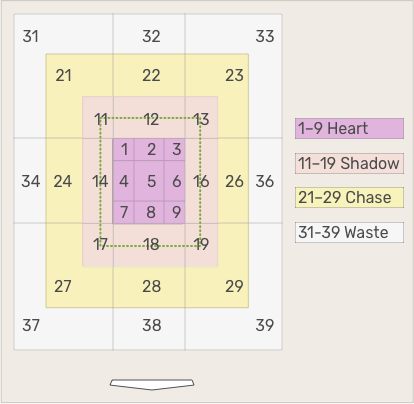

In [4]:
display(Image('attack-zone.png'))

In [ ]:
# ignoring warnings
warnings.filterwarnings("ignore")

# Fetch the Statcast data for the 2024 season
season_data = statcast(start_dt="2024-03-20", end_dt="2024-10-31")

# Display the first few rows of the data
season_data.head()


This is a large query, it may take a moment to complete


100%|██████████| 226/226 [04:13<00:00,  1.12s/it]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
164,KC,2024-10-30,77.5,-1.11,5.65,"Buehler, Walker",657077,621111,strikeout,swinging_strike_blocked,...,1,4,2,1,<NA>,<NA>,5.23,-1.08,1.08,53.2
173,KC,2024-10-30,78.7,-1.01,5.73,"Buehler, Walker",657077,621111,NaN,swinging_strike,...,1,4,2,1,<NA>,<NA>,5.28,-1.05,1.05,54.2
182,FC,2024-10-30,93.1,-1.19,5.53,"Buehler, Walker",657077,621111,NaN,swinging_strike,...,1,4,2,1,<NA>,<NA>,1.89,-0.53,0.53,44.8
193,KC,2024-10-30,78.5,-1.19,5.7,"Buehler, Walker",657077,621111,NaN,ball,...,1,4,2,1,<NA>,<NA>,5.16,-1.05,1.05,51.9
196,KC,2024-10-30,77.4,-1.23,5.78,"Buehler, Walker",669224,621111,strikeout,swinging_strike,...,1,4,2,1,<NA>,<NA>,5.2,-1.08,1.08,50.0


Below is our data aggregation, per the comments in the code blocks

In [ ]:
# Group by 'game_pk' for each game
aggregated_data = []

# function for aggregating team-level pitching data in each game
def calculate_team_aggregates(team_data, team, home_team, away_team, game_date):
    """Calculate aggregate metrics for a given team."""
    # Averages
    avg_release_speed = team_data['release_speed'].mean()
    avg_release_pos_x = team_data['release_pos_x'].mean()
    avg_release_pos_z = team_data['release_pos_z'].mean()
    avg_balls = team_data['balls'].mean()
    avg_strikes = team_data['strikes'].mean()
    avg_pfx_x = team_data['pfx_x'].mean()
    avg_pfx_z = team_data['pfx_z'].mean()
    avg_plate_x = team_data['plate_x'].mean()
    avg_plate_z = team_data['plate_z'].mean()
    avg_outs_when_up = team_data['outs_when_up'].mean()
    avg_effective_speed = team_data['effective_speed'].mean()
    avg_release_spin = team_data['release_spin_rate'].mean()
    avg_release_extension = team_data['release_extension'].mean()
    avg_release_pos_y = team_data['release_pos_y'].mean()
    avg_spin_axis = team_data['spin_axis'].mean()

    # Modes (categorical columns with error handling)
    mode_zone = team_data['zone'].mode()
    mode_zone = mode_zone.iloc[0] if not mode_zone.empty else None

    mode_stand = team_data['stand'].mode()
    mode_stand = mode_stand.iloc[0] if not mode_stand.empty else None

    mode_p_throws = team_data['p_throws'].mode()
    mode_p_throws = mode_p_throws.iloc[0] if not mode_p_throws.empty else None

    return {
        'Team': team,
        'home_team': home_team,
        'away_team': away_team,
        'game_date': game_date,
        'avg_release_speed': avg_release_speed,
        'avg_release_pos_x': avg_release_pos_x,
        'avg_release_pos_z': avg_release_pos_z,
        'avg_balls': avg_balls,
        'avg_strikes': avg_strikes,
        'avg_pfx_x': avg_pfx_x,
        'avg_pfx_z': avg_pfx_z,
        'avg_plate_x': avg_plate_x,
        'avg_plate_z': avg_plate_z,
        'avg_outs_when_up': avg_outs_when_up,
        'avg_effective_speed': avg_effective_speed,
        'avg_release_spin_rate': avg_release_spin,
        'avg_release_extension': avg_release_extension,
        'avg_release_pos_y': avg_release_pos_y,
        'avg_spin_axis': avg_spin_axis,
        'mode_zone': mode_zone,
        'mode_stand': mode_stand,
        'mode_p_throws': mode_p_throws,
    }

# Process each game
for game_pk, game_data in season_data.groupby('game_pk', sort=False):
    game_date = game_data['game_date'].iloc[0]
    home_team = game_data['home_team'].iloc[0]
    away_team = game_data['away_team'].iloc[0]

    # Home team (Top inning corresponds to pitches by the home team)
    home_team_data = game_data[game_data['inning_topbot'] == 'Top']
    aggregated_data.append(calculate_team_aggregates(home_team_data, home_team, home_team, away_team, game_date))

    # Away team (Bot inning corresponds to pitches by the away team)
    away_team_data = game_data[game_data['inning_topbot'] == 'Bot']
    aggregated_data.append(calculate_team_aggregates(away_team_data, away_team, home_team, away_team, game_date))

# Create the synthesized dataset as a DataFrame
statcast_data = pd.DataFrame(aggregated_data)

In [ ]:
statcast_data.head()

,Team,home_team,away_team,game_date,avg_release_speed,avg_release_pos_x,avg_release_pos_z,avg_balls,avg_strikes,avg_pfx_x,...,avg_plate_z,avg_outs_when_up,avg_effective_speed,avg_release_spin_rate,avg_release_extension,avg_release_pos_y,avg_spin_axis,mode_zone,mode_stand,mode_p_throws
0,NYY,NYY,LAD,2024-10-30,91.653846,-2.325705,5.972628,0.782051,0.807692,-0.280449,...,2.365769,1.038462,91.200641,2288.692308,6.262821,54.238974,175.788462,11.0,L,R
1,LAD,NYY,LAD,2024-10-30,90.336022,-1.534892,5.881505,1.145161,0.784946,0.010054,...,2.267796,1.102151,90.037634,2423.403226,6.314516,54.184516,167.451613,14.0,L,R
2,NYY,NYY,LAD,2024-10-29,91.153237,-1.466331,5.858129,0.928058,0.928058,0.068705,...,2.426043,0.834532,91.255396,2199.906475,6.533813,53.969712,162.244604,11.0,L,R
3,LAD,NYY,LAD,2024-10-29,89.31716,-1.267633,6.001716,1.053254,0.940828,-0.076686,...,2.355799,0.875740,88.782249,2380.43787,6.092899,54.407456,172.816568,14.0,L,R
4,NYY,NYY,LAD,2024-10-28,88.54908,-0.786503,5.514601,1.079755,0.852761,0.264908,...,2.385276,0.828221,88.369325,2460.993865,6.382209,54.116503,148.687117,14.0,L,R


In [ ]:
# Ensure game_date is a datetime in both datasets
statcast_data['game_date'] = pd.to_datetime(statcast_data['game_date'])
OG_data['game_date'] = pd.to_datetime(OG_data['game_date'])

# Merge the datasets on the specified common columns
final_merged_data = pd.merge(
    OG_data,
    statcast_data,
    on=["home_team", "away_team", "Team", "game_date"],
    how="inner"
)

# Save the merged_data as final_data_clean.csv
final_merged_data.to_csv("final.csv", index=False)

# Assign merged_data to data for further use
data = final_merged_data


We decided we had a satisfactory dataset to work with at this point!

## Imputing, Scaling, and Train/Test split

We quickly noticed that the averaged pitch-level statcast data in each game had some categorical variables (the mode ones), a few missing entries, and a variety of ranges in the numerical variables.

First, to address categorical variables: for the binary predictors of left vs. right handed pitching and catching, we decided to encode left as 0 and right as 1. Rather than make 2 dummy variables for each predictor, we realized it was more efficient to encode them (since these are binary predictors).

For the mode pitching "zone" (which region of the strike zone the pitcher pitches to most frequently), we one-hot encoded using dummy variables for each zone, as there are 14 possible values.

A few of our columns had missingness, as seen below. Because of this, we used mean imputing to impute the average for each of those stats. Because each row was only missing at most a few statistics out of dozens, we opted for imputing rather than throwing out these entries. Additionally, due to the size of our dataset, we were comfortable that imputing would not have a noticeable effect.

Finally, to address the scale of predictors, we used a standard scaler to normalize the values of the features and prevent scale from influencing coefficients in our parametric models.

Following our previous steps, we implemented a 70-30 Train-Test split for consistent usage in our upcoming models.

In [ ]:
data = pd.read_csv('final.csv')
# Missingness
data.isnull().sum()

,0
game_date,0
home_team,0
away_team,0
catcher_id,0
Name,0
MLBAMID,0
Team,0
STD_POS,0
fav_h,0
umpire,0


In [ ]:
# Binary and one-hot encoding of categorical variables
data['mode_stand'] = data['mode_stand'].map({'L': 0, 'R': 1})
data['mode_p_throws'] = data['mode_p_throws'].map({'L': 0, 'R': 1})
data = data.rename(columns={'mode_stand': 'mode_batter_stand_right', 'mode_p_throws': 'mode_pitcher_throws_right'})
data = pd.get_dummies(data, columns=['mode_zone'], prefix=['mode_zone'], dtype=int)

# set predictor and target variables
X = data.iloc[:, 10:]
y = data['fav_h']

# extracting feature_names
feature_names = X.columns.tolist()

# impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# training final model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
feature_names

['strike_rate',
 'catcher_bias',
 'umpire_bias',
 'interaction_home_umpire',
 'avg_release_speed',
 'avg_release_pos_x',
 'avg_release_pos_z',
 'avg_balls',
 'avg_strikes',
 'avg_pfx_x',
 'avg_pfx_z',
 'avg_plate_x',
 'avg_plate_z',
 'avg_outs_when_up',
 'avg_effective_speed',
 'avg_release_spin_rate',
 'avg_release_extension',
 'avg_release_pos_y',
 'avg_spin_axis',
 'mode_batter_stand_right',
 'mode_pitcher_throws_right',
 'mode_zone_2.0',
 'mode_zone_4.0',
 'mode_zone_5.0',
 'mode_zone_6.0',
 'mode_zone_8.0',
 'mode_zone_11.0',
 'mode_zone_12.0',
 'mode_zone_13.0',
 'mode_zone_14.0']

# 3. Exploratory Data Analysis (EDA)

This is a choose-your-own-adventure type of section. We tried different visualizations to pick out any apparent anomalies and garner relationships within the data.

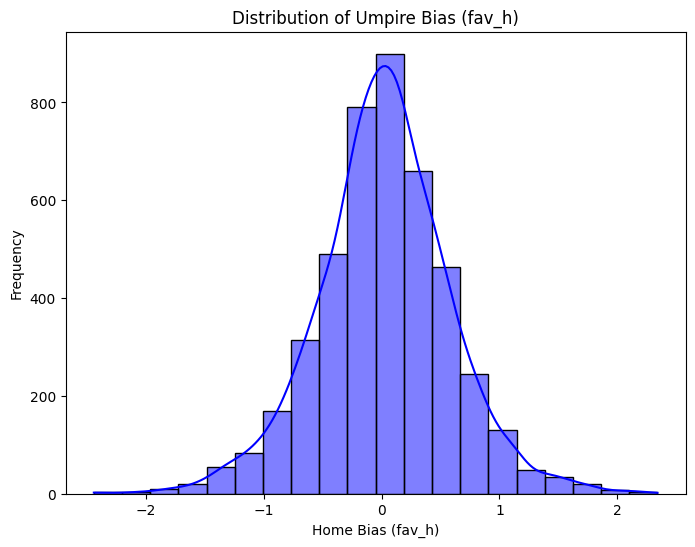

In [ ]:
data = pd.read_csv("final.csv")

# distribution of umpire bias
plt.figure(figsize=(8, 6))
sns.histplot(data['fav_h'], kde=True, bins=20, color='blue')
plt.title("Distribution of Umpire Bias (fav_h)")
plt.xlabel("Home Bias (fav_h)")
plt.ylabel("Frequency")
plt.show()

Histogram:
- Distribution of Bias seems pretty Gaussian and centered around 0 with a slight left skew (aligns with expectations of mostly "fair" umps)

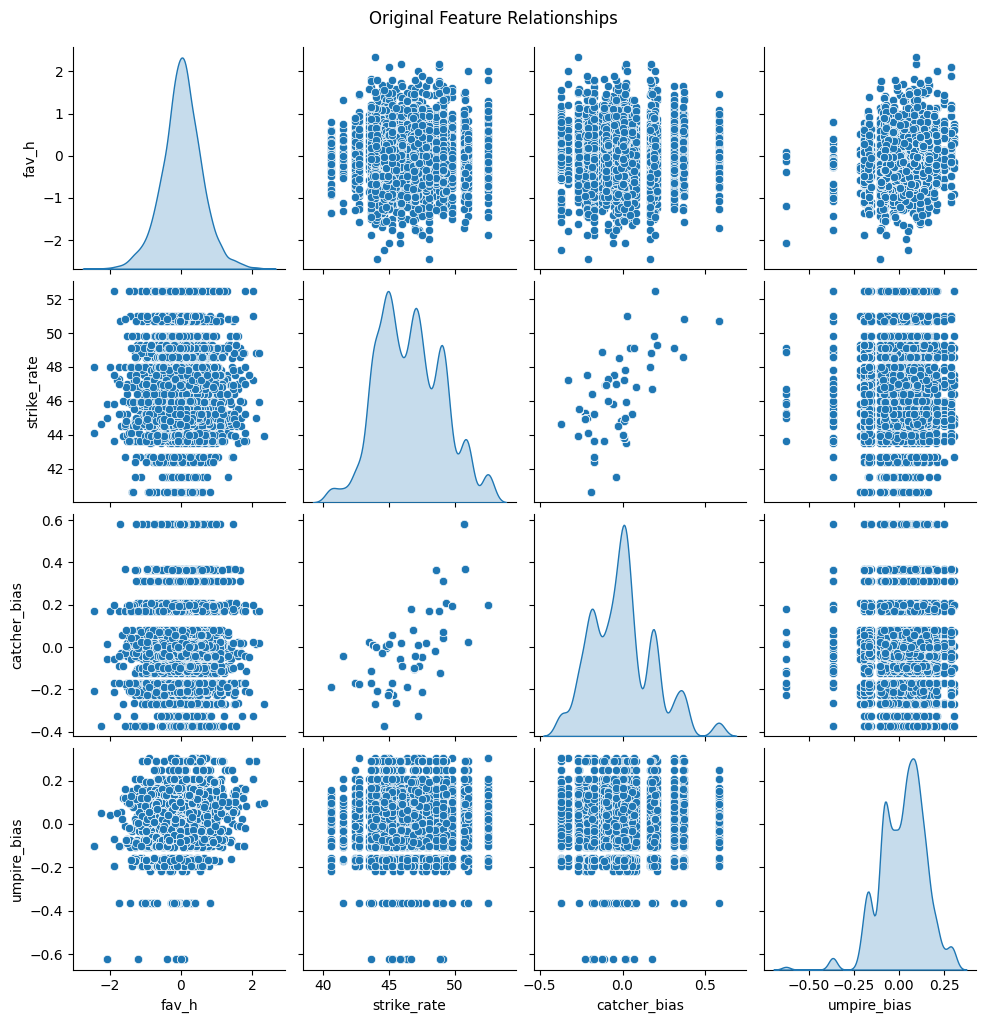

In [ ]:
# pairplot of original feature relationships + response
sns.pairplot(data[['fav_h', 'strike_rate', 'catcher_bias', 'umpire_bias']], diag_kind='kde')
plt.suptitle("Original Feature Relationships", y=1.02)
plt.show()

Original Feature Pairwise Plot:
- Relatively strong positive relationship between strike_rate and catcher_bias (higher strike rates at home may interplay/contribute to bias favoring the home team)
- Seemingly positive relationship with umpire_bias and fav_h (what we expect since umpire bias is the average of all individual game biases)
- fav_h against itself looks more Gaussian than the others


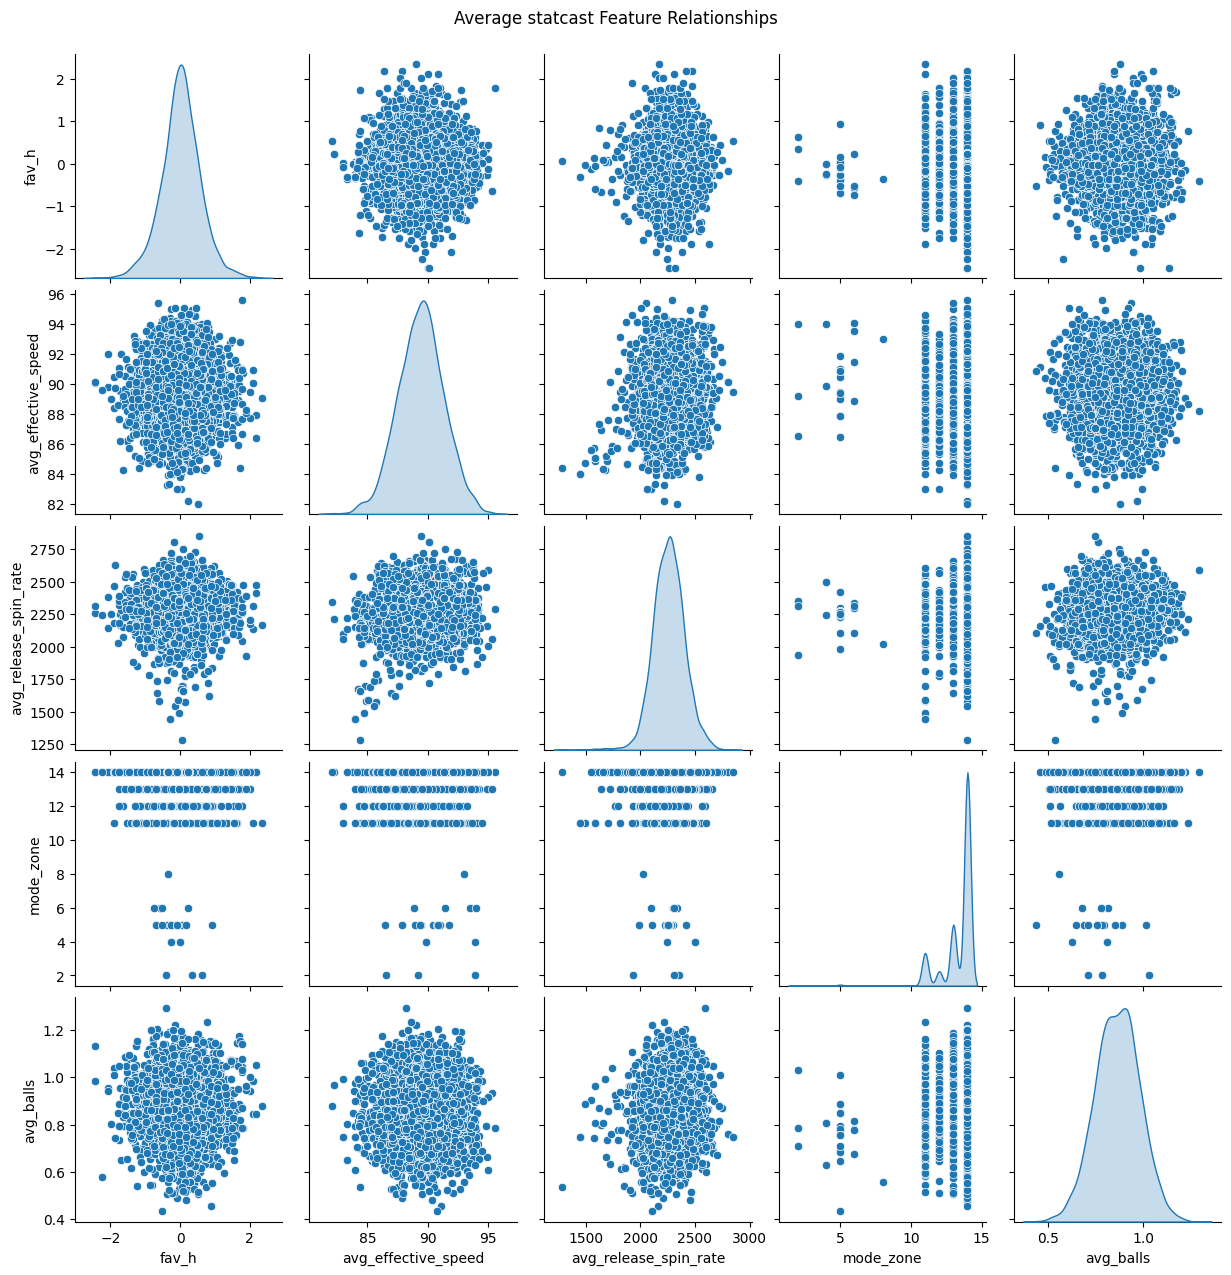

In [ ]:
# pairplot of some statcast feature relationships + response
sns.pairplot(data[['fav_h', 'avg_effective_speed', 'avg_release_spin_rate', 'mode_zone', 'avg_balls' ]], diag_kind='kde')
plt.suptitle("Average statcast Feature Relationships", y=1.02)
plt.show()

Statcast Feature Pairwise Plot:
- No relationships as strong as in the previous pairwise plot, but avg_release_spin rate seems to be positively associated with avg_effective_speed
- Overall fewer pitches thrown in the heart of the zone than in the shadow/chase/waste zones (makes sense because pitchers don't want to give up lollipops, but there may be an imbalance in the dataset that we need to be wary of)
- Features seem more normally distributed when plotted against themselves (makes sense since we're aggregating over TONS of pitches)

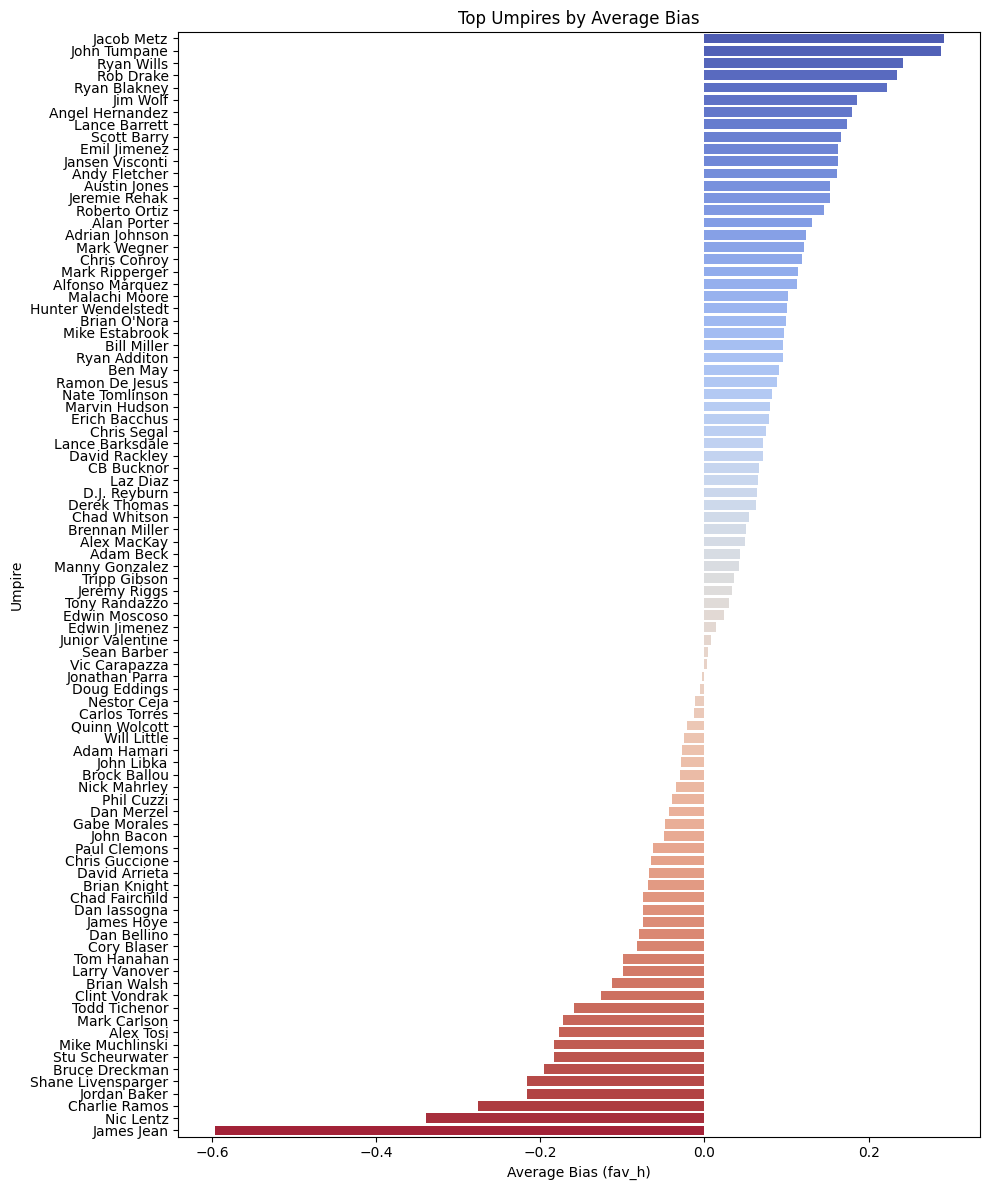

In [ ]:
# top umpires by bias
umpire_bias_summary = data.groupby('umpire')['fav_h'].mean().reset_index().sort_values(by='fav_h', ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(data=umpire_bias_summary, y='umpire', x='fav_h', palette='coolwarm')
plt.title("Top Umpires by Average Bias")
plt.xlabel("Average Bias (fav_h)")
plt.ylabel("Umpire")
plt.tight_layout()
plt.show()

Umpires by Average Bias:
- More umpires seem to exhibit bias favoring the home team, which corroborates the general theory of home-field advantage
- James Jean seems like an outlier (almost double bias magnitude of anyone else)
- Other than the three most away-biased umps, magnitudes of away-biased and home-biased seem to have decent symmetry
- Fun Note: Angel Hernandez, the umpire most frequently and famously criticized for his missed calls, is among the more home-biased umpires, though not at the top of the list. It seems that he is deserving of some criticism for his mistakes, though he is not our biggest culprit.

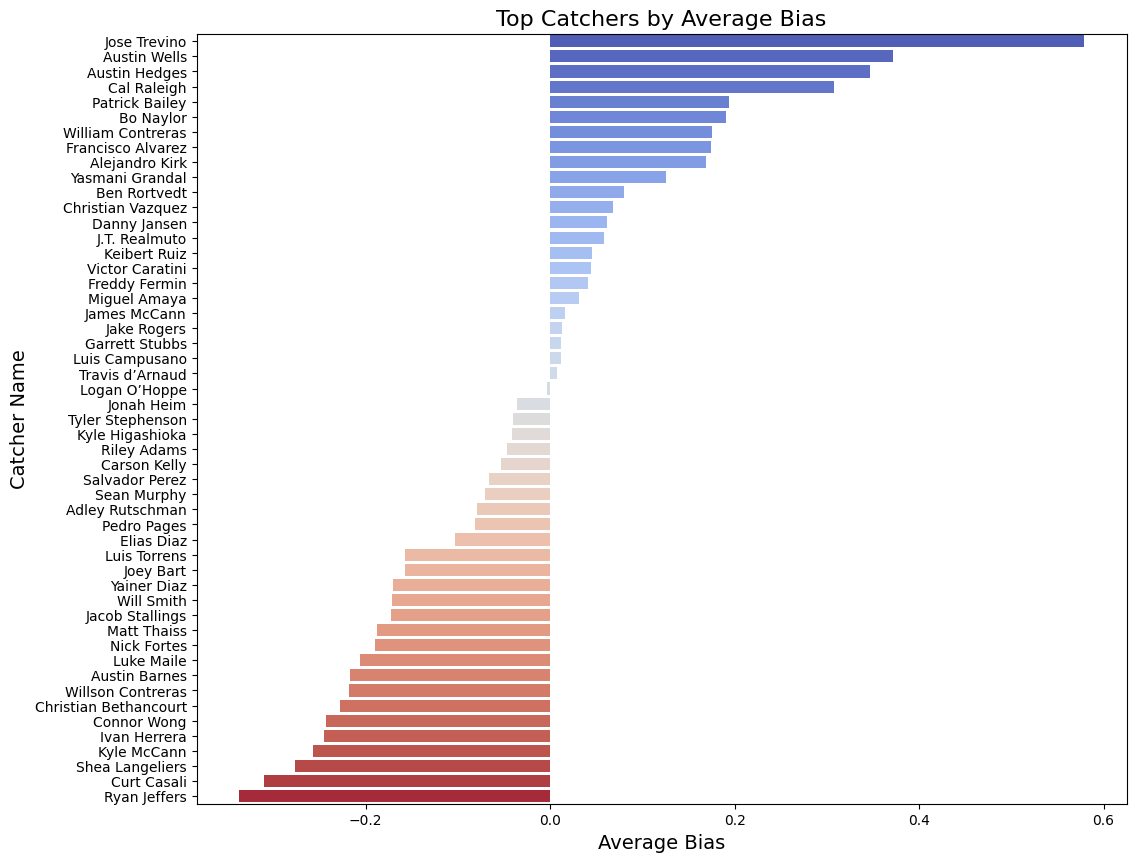

In [ ]:


home_data = data[data['Team'] == data['home_team']]
away_data = data[data['Team'] == data['away_team']]

home_fav_h = home_data.groupby(['catcher_id', 'Name'])['fav_h'].mean().reset_index()
away_fav_h = away_data.groupby(['catcher_id', 'Name'])['fav_h'].mean().reset_index()

merged_fav_h = pd.merge(home_fav_h, away_fav_h, on=['catcher_id', 'Name'], suffixes=('_home', '_away'))
merged_fav_h['fav_h_diff'] = merged_fav_h['fav_h_home'] - merged_fav_h['fav_h_away']

#Plot
plt.figure(figsize=(12, 10))
sns.barplot(data=merged_fav_h.sort_values(by='fav_h_diff', ascending=False), y='Name', x='fav_h_diff', palette='coolwarm')
plt.title("Top Catchers by Average Bias", fontsize=16)
plt.xlabel("Average Bias", fontsize=14)
plt.ylabel("Catcher Name", fontsize=14)
plt.show()

Catchers by Average Bias:
- Jose Trevino seems to be the standout top catcher in terms of highest bias in his favor. Austin Wells, Austin Hedges, Cal Raleigh, and Patrick Bailey round out the top 5. All 5 of these appear in the top 10 Catcher Framing Leaders according to Statcast's own measures, meaning the metric here used in EDA is effective.

Perhaps crowd noise effects, inherent desire for shorter games (since home doesn't bat in Bot 9 if winning), or other confounders may provide insight of the overall observed tendency toward favoring the home team. However, exploring those relationships was outside our scope and any dataset we could reasonably get our hands on.

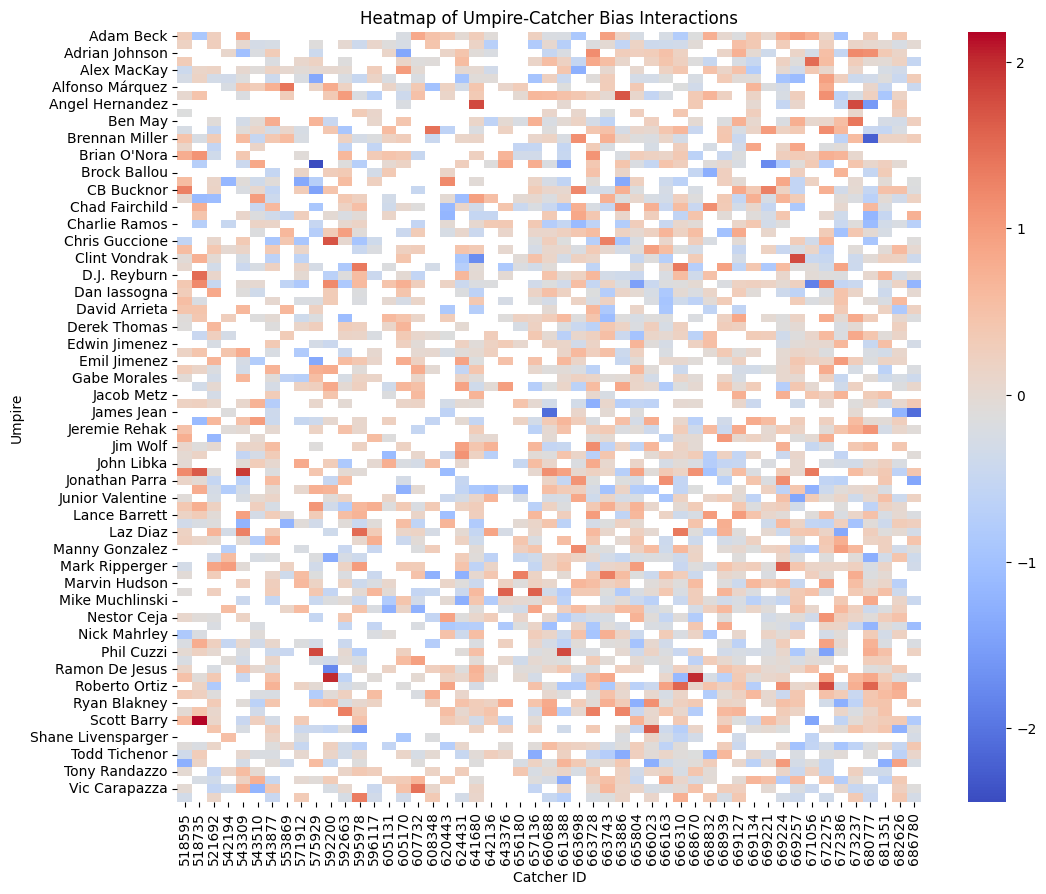

In [ ]:
# heatmap of umpire-catcher interactions
interaction_matrix = data.pivot_table(index='umpire', columns='catcher_id', values='fav_h', aggfunc='mean')
plt.figure(figsize=(12, 10))
sns.heatmap(interaction_matrix, cmap='coolwarm', annot=False, cbar=True)
plt.title("Heatmap of Umpire-Catcher Bias Interactions")
plt.xlabel("Catcher ID")
plt.ylabel("Umpire")
plt.show()

Heatmap:
- Overwhelmingly translucent colors and no distinguishable patterns
- No clear trend of catchers experiencing more extreme bias from one ump consistently experiencing more extreme bias from other umps (except maybe for catcher 592200, Curt Casali)
  - This may suggest that bias isn't quite as dependent on catcher "framing" as many fans make it out to be


# 4. Modeling

In [ ]:
# list of dictionaries with (model_name, train_MSE, val_MSE, test_MSE)
model_performances = []

## Morgan's (Naive) Model

A naive baseline model would be to predict the **average target value (`fav_h`)** for all games. This will serce as a benchmark to understand if engineering features and more advanced models can improve predictive accuracy in the first place. We use MSE to measure baseline performance.

The baseline model assumes:
- No relationship b/w the predictors and the target.
- All predictions are equal to the mean of `fav_h`.

Any model that outperforms this naive prediction should be considered valuable.

In [ ]:
# baseline model: predict the avg target vals on training set
baseline_pred = np.mean(y_train)

In [ ]:
# Calculate baseline MSE
baseline_train_mse = mean_squared_error(y_train, [baseline_pred] * len(y_train))
baseline_test_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))

# Calculate R^2 on test data
baseline_test_r2 = r2_score(y_test, [baseline_pred] * len(y_test))

# Print results
print(f"Baseline Train MSE: {baseline_train_mse:.4f}")
print(f"Baseline Test MSE: {baseline_test_mse:.4f}")
print(f"Baseline Test R^2: {baseline_test_r2:.4f}")




Baseline Train MSE: 0.3034
Baseline Test MSE: 0.3501
Baseline Test R^2: -0.0007


In [ ]:
# updating list
model_performances.append(
    {
        'model_name': "Naive Model (arithmetic average)",
        'train_mse': baseline_train_mse,
        'test_mse': baseline_test_mse,
        'test_rmse': np.sqrt(baseline_test_mse),
        'r-squared': baseline_test_r2
    }
)


## KNN Regression

kNN Regression is a non-parametric regression technique that may be helpful in modeling non-linear relationships between predictors and our response variable fav_h. A higher value of k will lead to higher model complexity, and this can be tuned via cross-validatoin.

Because of this, we expect it to outperform the naive model, and perhaps our simplest decision tree model, but we do not expect it to do as well as our more thorough methods like Random Forest, Bagging, or Boosting.

Optimal K (Cross-Validation): 67


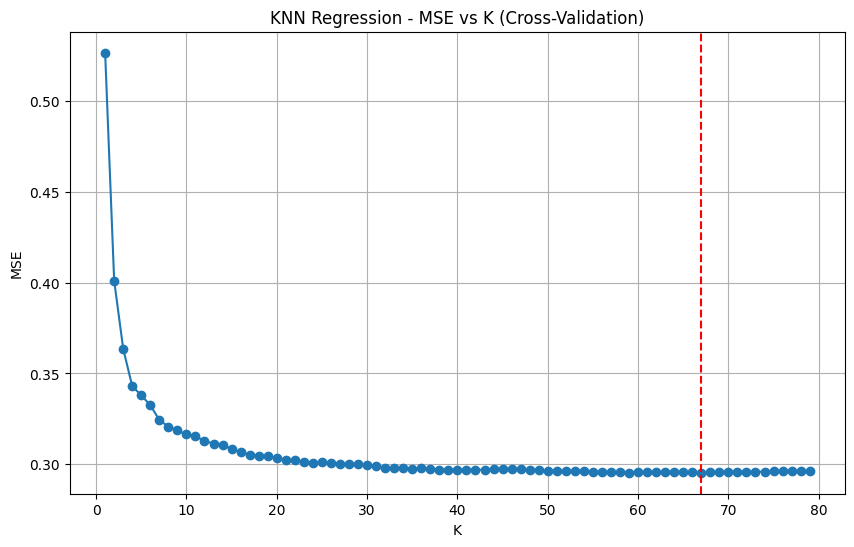


Train MSE: 0.2861
Test MSE: 0.3451


In [ ]:
# Training optimal knn using cross validation
mse_values_cv = []
k_values = range(1, 80)


for k in k_values:
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    neg_mse = cross_val_score(knn_reg, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=5)
    mse_values_cv.append(-np.mean(neg_mse))

optimal_k_cv = k_values[np.argmin(mse_values_cv)]
print(f"Optimal K (Cross-Validation): {optimal_k_cv}")

#Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values_cv, marker='o')
plt.axvline(x=optimal_k_cv, color='red', linestyle='--', label=f'Optimal K = {optimal_k_cv}')
plt.title("KNN Regression - MSE vs K (Cross-Validation)")
plt.xlabel("K")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# Train, Validation, Test MSE of model with optimal_k_cv
knn_reg = KNeighborsRegressor(n_neighbors=optimal_k_cv)
knn_reg.fit(X_train, y_train)

# Train, validation, test MSE
y_pred_train = knn_reg.predict(X_train)
y_pred_test = knn_reg.predict(X_test)
knn_train_mse = mean_squared_error(y_train, y_pred_train)
knn_test_mse = mean_squared_error(y_test, y_pred_test)
r2_final = r2_score(y_test, y_pred_test)

# Print results
print(f"\nTrain MSE: {knn_train_mse:.4f}")
print(f"Test MSE: {knn_test_mse:.4f}")



In [ ]:
# update list
model_performances.append(
    {
        'model_name': f"KNN ({optimal_k_cv} neighbors)",
        'train_mse': knn_train_mse,
        'test_mse': knn_test_mse,
        'test_rmse': np.sqrt(knn_test_mse),
        'r-squared': r2_final
    }
)

### Feature Importance

We can see that umpire bias is by far the most important feature, followed by pitching statistics regarding spin rate and release, as well as batter stance.

In [ ]:
# Get permutation importance from kNN regression
knn_permutation_importance = permutation_importance(knn_reg, X_test, y_test, n_repeats=30, random_state=42)
importance_values = knn_permutation_importance.importances_mean

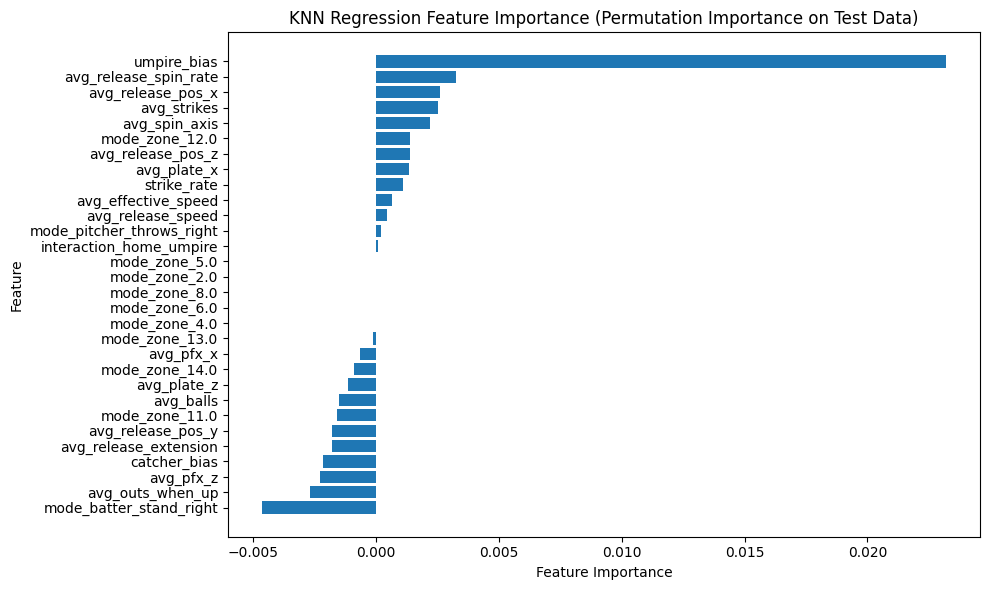

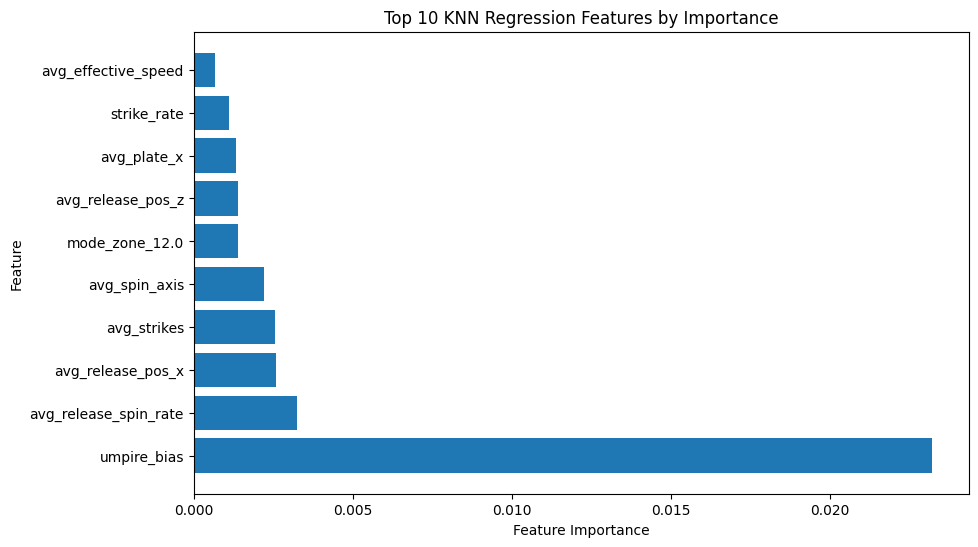

In [ ]:
# Sort importance values and feature names
sorted_indices = importance_values.argsort()
sorted_importance_values = importance_values[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_values)
plt.title("KNN Regression Feature Importance (Permutation Importance on Test Data)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Plot top 10 features
top_indices = np.argsort(importance_values)[::-1][:10]
top_features = [feature_names[i] for i in top_indices]
top_importances = importance_values[top_indices]


plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.title("Top 10 KNN Regression Features by Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## Linear Regression with Ridge Regularization

Linear regression will assume a linear relationship between our predictors and response. This model will perform well if that assumption is correct, but will not do as well if the relationship is more complicated and nonlinear (which is likely for at least some predictors). Ridge regularization will help prevent overfitting by shrinking coefficients and optimizing the bias-variance tradeoff.

Given that a linear approximation may not be the ideal relationship between our features and bias, we expect linear regression with ridge regularization to improve upon the baseline model, but be less accurate than non-parametric or ensemble methods like kNN and Random Forest.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Optimal alpha: 0.01 

Ridge Train MSE (Optimal Alpha): 0.2825
Ridge Test MSE (Optimal Alpha): 0.3406
Ridge Test R^2 (Optimal Alpha): 0.0265 



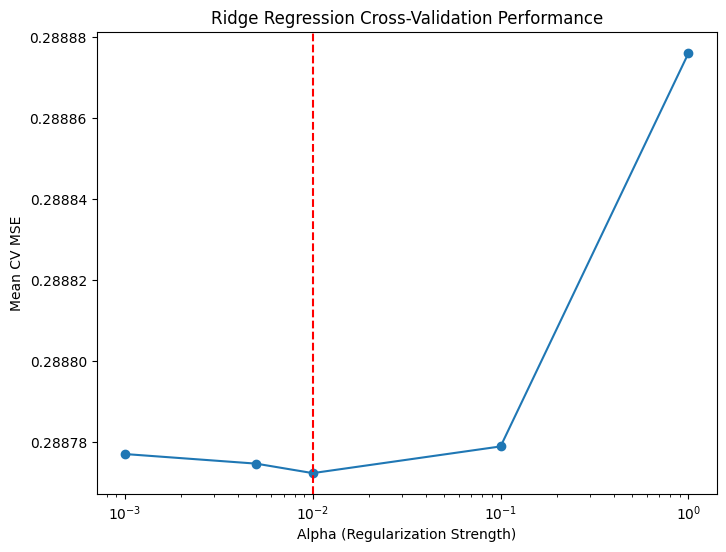

In [ ]:
# Define the range of alpha values to test
alpha_values = [0.001, 0.005, 0.01, 0.1, 1]

# Set up GridSearchCV to find the best alpha
ridge_cv = GridSearchCV(
    Ridge(),
    param_grid={'alpha': alpha_values},
    scoring='neg_mean_squared_error',  # Use negative MSE for scoring
    cv=5,  # 5-fold cross-validation
    verbose=1
)

# Fit GridSearchCV on the training data
ridge_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Optimal alpha: {best_alpha} \n")

# Train the Ridge model with the optimal alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Predict on training and test sets
y_pred_train_ridge = ridge_best.predict(X_train)
y_pred_test_ridge = ridge_best.predict(X_test)

# Evaluate the model
ridge_train_mse = mean_squared_error(y_train, y_pred_train_ridge)
ridge_test_mse = mean_squared_error(y_test, y_pred_test_ridge)
ridge_r2 = r2_score(y_test, y_pred_test_ridge)

# Print results
print(f"Ridge Train MSE (Optimal Alpha): {ridge_train_mse:.4f}")
print(f"Ridge Test MSE (Optimal Alpha): {ridge_test_mse:.4f}")
print(f"Ridge Test R^2 (Optimal Alpha): {ridge_r2:.4f} \n")

# Get mean CV scores for each alpha (convert negative MSE to positive)
cv_results = -ridge_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(alpha_values, cv_results, marker='o')
plt.xscale('log')  # Use a log scale for alpha
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Optimal Alpha = {best_alpha}')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean CV MSE')
plt.title('Ridge Regression Cross-Validation Performance')
plt.show()

In [ ]:
# updating list
model_performances.append(
    {
        'model_name': f"Ridge Regression (Alpha = {best_alpha})",
        'train_mse': ridge_train_mse,
        'test_mse': ridge_test_mse,
        'test_rmse': np.sqrt(ridge_test_mse),
        'r-squared': ridge_r2
    }
)


### Feature Importance

Release position and extension for pitching appear the most important here, a departure from other models.

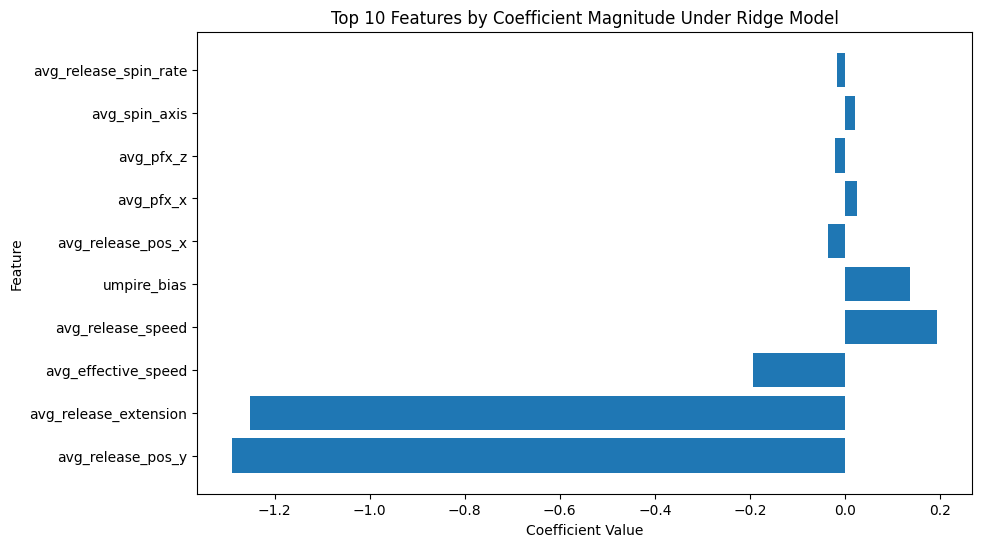

In [ ]:
coefficients = ridge_best.coef_

# Plot top 10 features
top_indices = np.argsort(np.abs(coefficients))[::-1][:10]
top_coefficients = coefficients[top_indices]

top_feature_names = [feature_names[i] for i in top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_coefficients)
plt.title("Top 10 Features by Coefficient Magnitude Under Ridge Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

**Residual Analysis:**
Showing that there's a fairly constant variance across residuals (homoskedacisity) supports our assumption of a linear relationship because

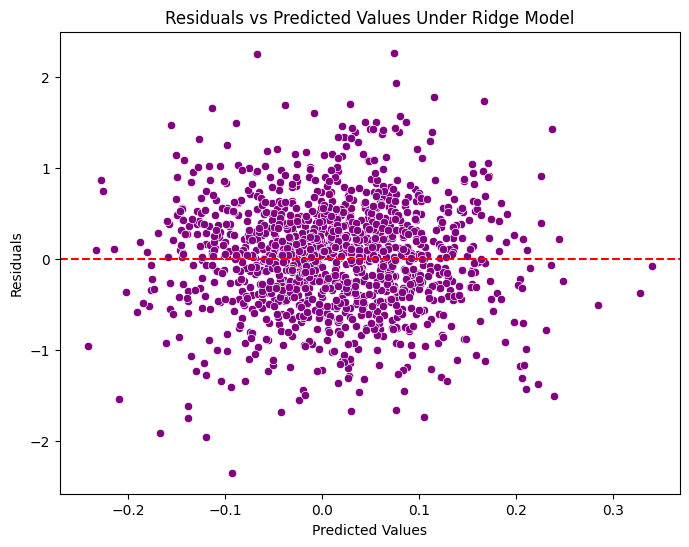

In [ ]:
# residual analysis
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values Under Ridge Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

## Single Regression Tree

A single regression decision tree is a simple model that will likely be unable to capture the complexities of our data. We learned several methods such as RF, Bagging, and Boosting to combine trees for better results, so we expect those ensemble learning methods to do much better compared to a single tree.

Optimal Depth (Cross-Validation): 1 



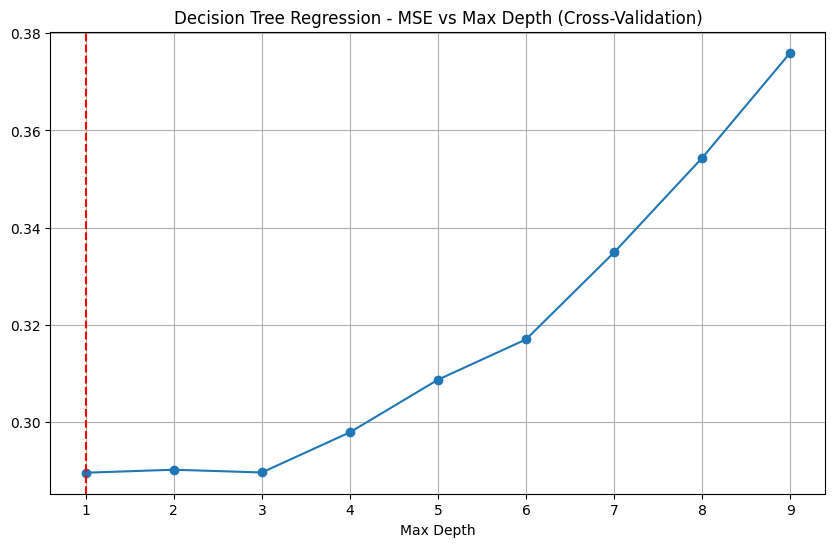

In [ ]:
# Best Depth CV
mse_values_cv = []

# Perform cross-validation for depths 1 to 9
depth_values = range(1, 10)
for i in depth_values:
    tree = DecisionTreeRegressor(max_depth=i, random_state=42)
    neg_mse = cross_val_score(tree, X_train, y_train,
                              scoring="neg_mean_squared_error", cv=5)
    mse_values_cv.append(-np.mean(neg_mse))

# Determine optimal depth
optimal_depth_cv = depth_values[np.argmin(mse_values_cv)]
print(f"Optimal Depth (Cross-Validation): {optimal_depth_cv} \n")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), mse_values_cv, marker='o')
plt.axvline(x=optimal_depth_cv, color='red', linestyle='--', label=f'Optimal Depth = {optimal_depth_cv}')
plt.title("Decision Tree Regression - MSE vs Max Depth (Cross-Validation)")
plt.xlabel("Max Depth")
plt.grid(True)
plt.show()

In [ ]:
# Retrain entire tree using optimal stopping condition
# Define the DecisionTreeRegressor with optimal depth
best_single_tree = DecisionTreeRegressor(max_depth=optimal_depth_cv, random_state=42)

# Train the model
best_single_tree.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = best_single_tree.predict(X_train)
y_test_pred = best_single_tree.predict(X_test)

# Calculate MSE for training and test sets
single_train_mse = mean_squared_error(y_train, y_train_pred)
single_test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate R^2 on test data
single_test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Single Tree Train MSE: {single_train_mse:.4f}")
print(f"Single Tree Test MSE: {single_test_mse:.4f}")
print(f"Single Tree Test R^2: {single_test_r2:.4f}")





Single Tree Train MSE: 0.2887
Single Tree Test MSE: 0.3527
Single Tree Test R^2: -0.0080


In [ ]:
# updating list
model_performances.append(
    {
        'model_name': f"Single Regression Tree (Depth = {optimal_depth_cv})",
        'train_mse': single_train_mse,
        'test_mse': single_test_mse,
        'test_rmse': np.sqrt(single_test_mse),
        'r-squared': single_test_r2
    }
)

### Feature Importance

Umpire bias appears the most important feature by far. Notice that fewer features can be used in a single tree.

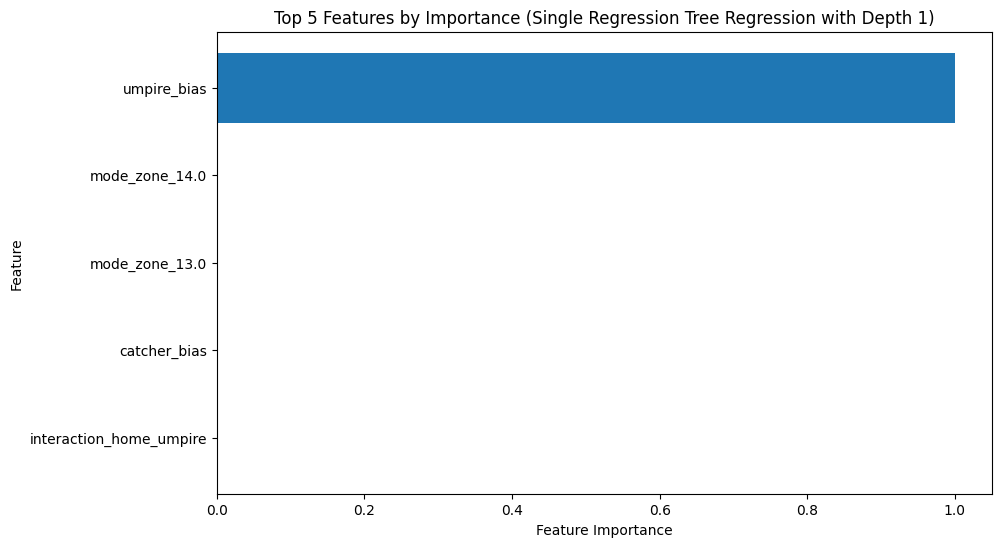


Note that there's at maximum 5 features usable in a simple tree with max_depth 3


In [ ]:
# Extract feature importances from the trained decision tree
feature_importances = best_single_tree.feature_importances_

# Get the indices of the top 10 features by importance
top_indices = np.argsort(feature_importances)[::-1][:5]

# Get the corresponding feature names and importances
top_features = [feature_names[i] for i in top_indices]
top_importances = feature_importances[top_indices]

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top 5 Features by Importance (Single Regression Tree Regression with Depth {optimal_depth_cv})")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

print("\nNote that there's at maximum 5 features usable in a simple tree with max_depth 3")

## Bagging

Bagging aims to reduce variance and improve accuracy by averaging predictions from multiple decision trees trained on different subsets of the data.

Because of this, we expect bagging to perform well due to its ability to handle complex relationships and reduce overfitting.

We expect it to outperform the simplest models like the single decision trees, and most likely to outperform kNN, due to ensemble learning's focus on variance reduction.

In [ ]:
# Define parameter grid for number of trees and max depth
param_grid = {
    'n_estimators': [200, 250, 300, 350, 400],  # Number of trees
    'estimator__max_depth': [25, 30, 35, 40, 45, None]  # Max depth of base decision tree
}

# Define the BaggingRegressor with a DecisionTreeRegressor as the base estimator
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    random_state=42
)

# Perform grid search for optimal parameters
grid_search = GridSearchCV(
    bagging,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Extract the optimal parameters and best score
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

optimal_n_estimators = best_params['n_estimators']
optimal_max_depth = best_params['estimator__max_depth']

print(f"Optimal # of estimators: {optimal_n_estimators}")
print(f"Optimal Subtree Depth: {optimal_max_depth}")
print(f"Best Cross-Validated MSE: {best_mse:.4f}")



Fitting 3 folds for each of 30 candidates, totalling 90 fits
Optimal # of estimators: 300
Optimal Subtree Depth: 35
Best Cross-Validated MSE: 0.2859


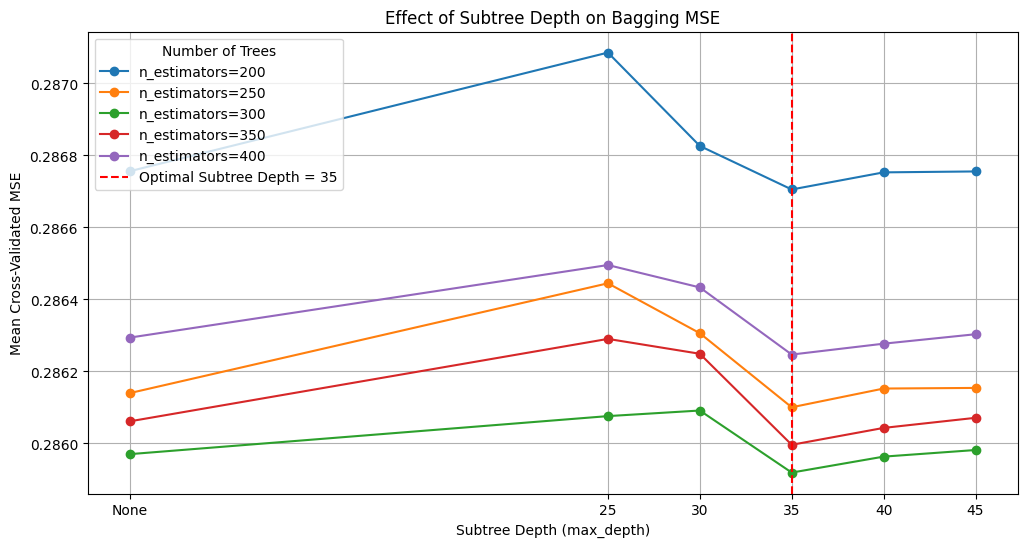

In [ ]:
# Create a DataFrame of the results
bag_results = pd.DataFrame(grid_search.cv_results_)

# Assuming `bag_results` is a DataFrame containing grid_search.cv_results_
# Convert negative mean test scores to positive MSE
bag_results['mean_test_mse'] = -bag_results['mean_test_score']

# Replace 'None' with a placeholder (e.g., -1) for sorting
bag_results['param_estimator__max_depth'] = bag_results['param_estimator__max_depth'].apply(
    lambda x: -1 if x is None else x
)

# Extract unique values for n_estimators
n_estimators_values = sorted(bag_results['param_n_estimators'].unique())

# Sort max_depth values such that -1 (placeholder for None) comes last
max_depth_values = sorted(
    [x for x in bag_results['param_estimator__max_depth'].unique() if x != -1]
) + [-1]

# Plot line graph for each `n_estimators`
plt.figure(figsize=(12, 6))
for n_estimators in n_estimators_values:
    subset = bag_results[bag_results['param_n_estimators'] == n_estimators]
    subset = subset.sort_values(by='param_estimator__max_depth')  # Ensure proper order
    plt.plot(
        subset['param_estimator__max_depth'],
        subset['mean_test_mse'],
        marker='o',
        label=f"n_estimators={n_estimators}"
    )

# Update x-ticks to display 'None' for depth placeholder (-1)
xticks = [x if x != -1 else 'None' for x in max_depth_values]
plt.xticks(ticks=max_depth_values, labels=xticks)

# Add labels, title, legend, and grid
# Check if optimal_max_depth is None and handle it for plotting
plotting_optimal_depth = optimal_max_depth if optimal_max_depth is not None else -1
plt.axvline(x=plotting_optimal_depth, color='red', linestyle='--', label=f'Optimal Subtree Depth = {optimal_max_depth}')
plt.xlabel("Subtree Depth (max_depth)")
plt.ylabel("Mean Cross-Validated MSE")
plt.title("Effect of Subtree Depth on Bagging MSE")
plt.legend(title="Number of Trees")
plt.grid(True)
plt.show()

In [ ]:
# Define and fit the bagging model with optimal parameters
final_base_estimator = DecisionTreeRegressor(max_depth=optimal_max_depth, random_state=42)
final_bagging_model = BaggingRegressor(estimator=final_base_estimator,
                                       n_estimators=optimal_n_estimators,
                                       random_state=42)

# Fit the model on the training data
final_bagging_model.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = final_bagging_model.predict(X_train)
y_test_pred = final_bagging_model.predict(X_test)

# Calculate performance metrics
bag_train_mse = mean_squared_error(y_train, y_train_pred)
bag_test_mse = mean_squared_error(y_test, y_test_pred)
bag_test_r2 = r2_score(y_test, y_test_pred)

print(f"Bagging Train MSE: {bag_train_mse:.4f}")
print(f"Bagging Test MSE: {bag_test_mse:.4f}")
print(f"Bagging Test R^2: {bag_test_r2:.4f}")


Bagging Train MSE: 0.0379
Bagging Test MSE: 0.3315
Bagging Test R^2: 0.0525


In [ ]:
# updating list
model_performances.append(
    {
        'model_name': f"Bagging (subtree depth {optimal_max_depth}, {optimal_n_estimators} estimators)",
        'train_mse': bag_train_mse,
        'test_mse': bag_test_mse,
        'test_rmse': np.sqrt(bag_test_mse),
        'r-squared': bag_test_r2
    }
)


### Feature Importance

Because Bagging trees are trained on different subsets of the data, more features appear in our feature importance. Umpire bias remains the most important, while avg balls, outs, and strikes when up now play a larger role, in addition to home-umpire interaction and pitch position on the plate.

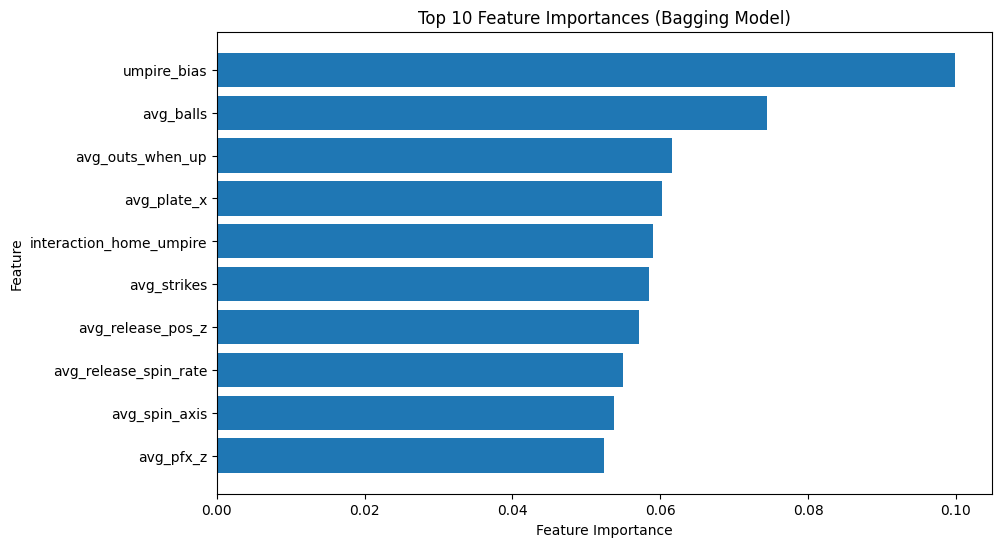

In [ ]:
# Aggregate feature importances from individual base estimators
feature_importances = np.mean(
    [tree.feature_importances_ for tree in final_bagging_model.estimators_], axis=0
)

# Get the indices of the top 10 features
top_indices = np.argsort(feature_importances)[::-1][:10]
top_features = [feature_names[i] for i in top_indices]
top_importances = feature_importances[top_indices]

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Bagging Model)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


## Random Forest

Random Forest further de-correlates trees compared to bagging, by randomly selecting a subset of features at each split. Beause of this, it is more robust to overfitting and better at dealing with complex relationships.

We expect its performance to be among the best, potentially even better than bagging, and certainly better than simpler models.

In [ ]:
# Grid Search RF

rf = RandomForestRegressor(random_state = 42, max_features = X_train.shape[1] // 3) # n/3 random features availible at each split
rf.fit(X_train, y_train)

param_grid = {
    'n_estimators': [150, 200, 250, 300, 350],  # Explore more values
    'max_depth': [30, 35, 40, 45, 50, None],  # Add `None` to test unbounded depth
}


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_['max_depth']
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Best Max Depth: {best_max_depth}")
print(f"Best n_estimators: {best_n_estimators}")

# Using best estimators
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for the best model (RandomizedSearchCV):", mse_rf)

Best Max Depth: 40
Best n_estimators: 250
Mean Squared Error for the best model (RandomizedSearchCV): 0.32908980786056324


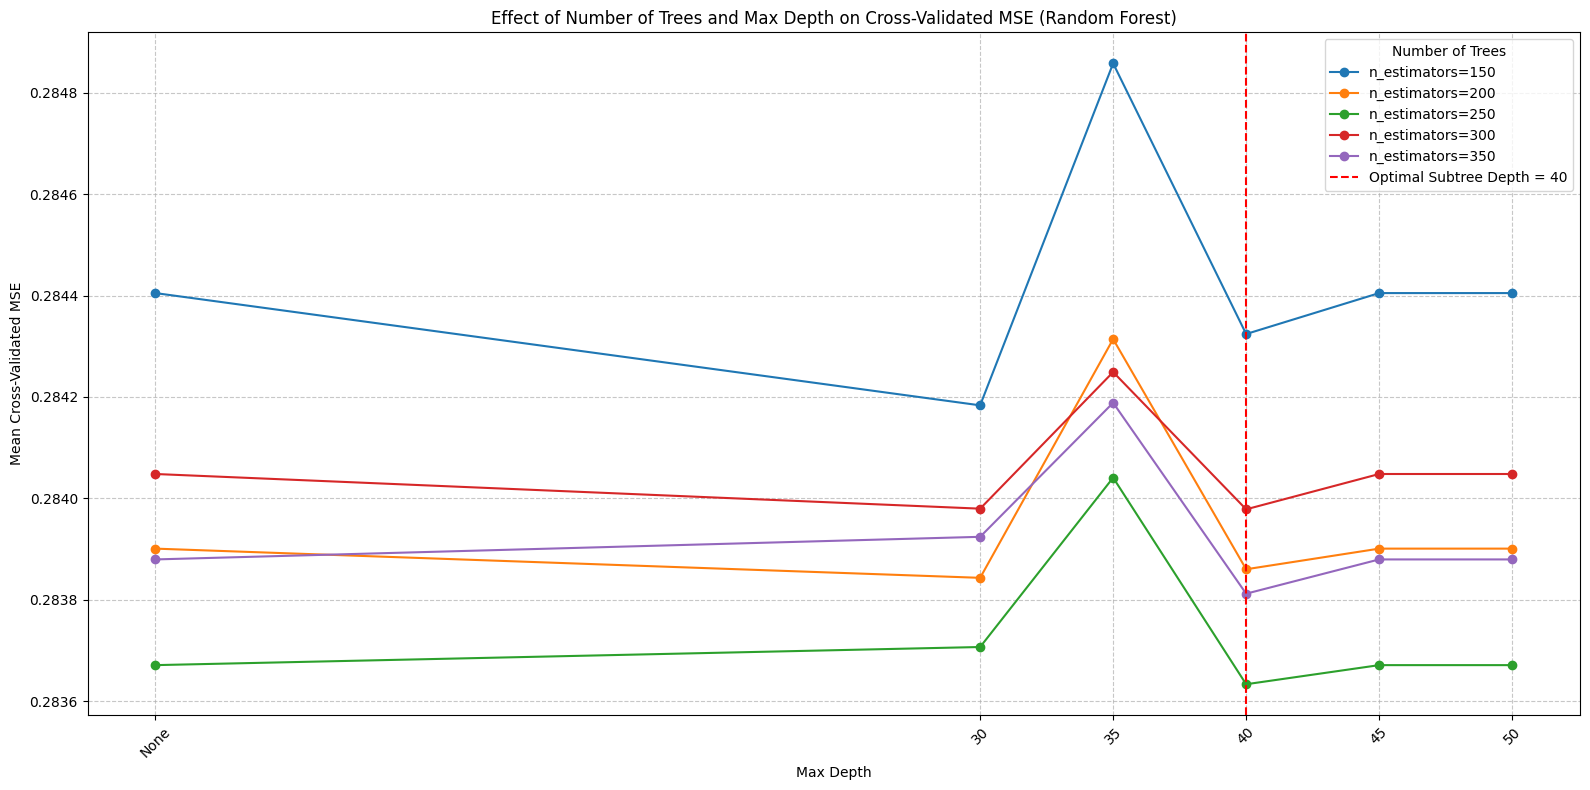

In [ ]:
# Extract the GridSearchCV results into a DataFrame and rename it
rf_cv_results = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive for better interpretation
rf_cv_results['mean_test_mse'] = -rf_cv_results['mean_test_score']

# Replace None with a placeholder (-1) for sorting, then move it to the leftmost
rf_cv_results['param_max_depth'] = rf_cv_results['param_max_depth'].apply(
    lambda x: -1 if x is None else x
)

# Sort max_depth values, ensuring -1 (None) is first
max_depth_values = sorted(rf_cv_results['param_max_depth'].unique())

# Plot results
plt.figure(figsize=(16, 8))  # Increased size for better readability
n_estimators_values = sorted(rf_cv_results['param_n_estimators'].unique())
for n_estimators in n_estimators_values:
    subset = rf_cv_results[rf_cv_results['param_n_estimators'] == n_estimators]
    subset = subset.sort_values(by='param_max_depth')
    plt.plot(
        subset['param_max_depth'],
        subset['mean_test_mse'],
        marker='o',
        label=f"n_estimators={n_estimators}"
    )

# Replace -1 with 'None' in x-ticks for display
xticks = ['None' if d == -1 else d for d in max_depth_values]
plt.xticks(ticks=max_depth_values, labels=xticks, rotation=45)  # Rotate for better readability

# Add labels, legend, and title
plt.axvline(x=best_max_depth, color='red', linestyle='--', label=f'Optimal Subtree Depth = {best_max_depth}')
plt.xlabel("Max Depth")
plt.ylabel("Mean Cross-Validated MSE")
plt.title("Effect of Number of Trees and Max Depth on Cross-Validated MSE (Random Forest)")
plt.legend(title="Number of Trees", loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()



In [ ]:
# Using best estimators
best_rf = grid_search.best_estimator_

# predictions
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# MSEs and test score
rf_train_mse = mean_squared_error(y_train, y_pred_train)
rf_test_mse = mean_squared_error(y_test, y_pred_test)
rf_test_score = best_rf.score(X_test, y_test)
rf_r2 = r2_score(y_test, y_pred_test)

print(f"Random Forest Train MSE: {rf_train_mse:.4f}")
print(f"Random Forest Test MSE: {rf_test_mse:.4f}")
print(f"Random Forest Test R^2: {rf_r2:.4f}")



Random Forest Train MSE: 0.0377
Random Forest Test MSE: 0.3291
Random Forest Test R^2: 0.0594


In [ ]:
# update list
model_performances.append(
    {
        'model_name': f"Random Forest (subsets of n/3 features at each split, max depth {best_max_depth}, {best_n_estimators} estimators)",
        'train_mse': rf_train_mse,
        'test_mse': rf_test_mse,
        'test_rmse': np.sqrt(rf_test_mse),
        'r-squared': rf_r2
    }
)

### Feature Importance

Because it selects a random subset of predictors for each tree, RF unsurprisingly has many important features, though umpire bias is back to the top, with avg balls, outs, and strikes, home-umpire interaction, and pitch position on the plate, remaining important as in bagging. These features keep showing up in our best models so are likely the truly most important ones.

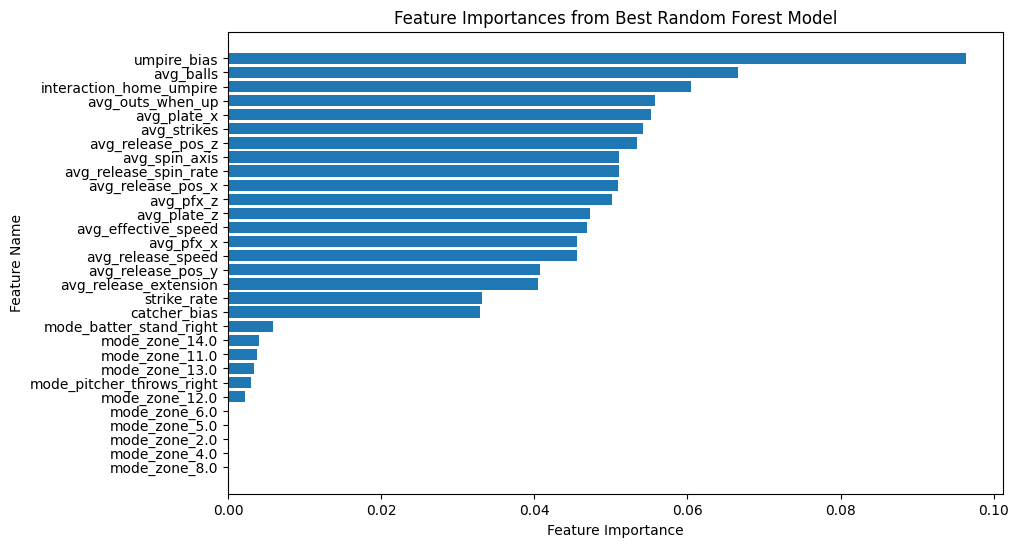

In [ ]:
# Get feature importances from the best random forest model
importances = best_rf.feature_importances_

# Sort feature importances and corresponding feature names
sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances from Best Random Forest Model')
plt.show()


## Boosting

Gradient Boosting will train an ensemble of trees sequentially, rather than parallel. Because of this, tuning our Boosting model took a much longer runtime (over double the times of other ensemble learning models), which we could have expected. Typically, this iterative process creates a model that is robust to overfitting and achieves strong accuracy.

We would expect boosting to be among our top models, like Bagging and RF. It's relatively weaker performance surprised us, and we will discuss this more in our conclusion/discussion.

In [ ]:
# parameter grid
param_grid = {
    'n_estimators': [450, 500, 550, 600, 650, 700],   # Number of iterations
    'max_depth': [1, 2, 3],                    # Depth of base learners
    'learning_rate': [0.001, 0.005, 0.01, 0.05] # learning rate
}


# Define the model
gb = GradientBoostingRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for optimization
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Extract the best parameters and the corresponding MSE
best_params = grid_search.best_params_

best_base_depth = best_params['max_depth']
best_n_estimators = best_params['n_estimators']
best_lambda = best_params['learning_rate']

print(f"Best Max Depth: {best_base_depth}")
print(f"Best n_estimators: {best_n_estimators}")
print(f"Best Learning Rate: {best_lambda}")

print(f"Best Cross-Validated MSE: {best_mse:.4f}")




Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Max Depth: 2
Best n_estimators: 550
Best Learning Rate: 0.01
Best Cross-Validated MSE: 0.2859


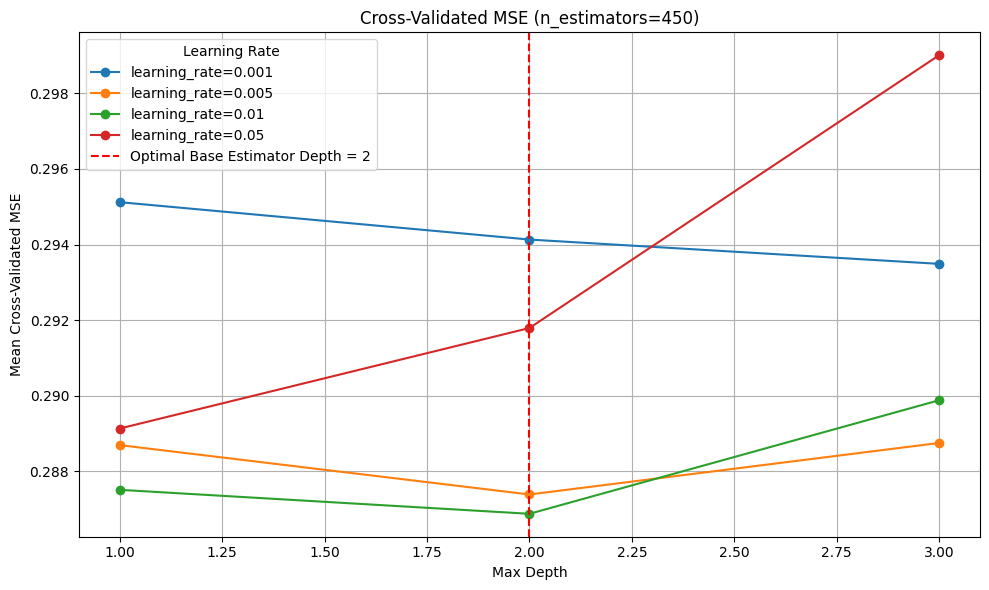

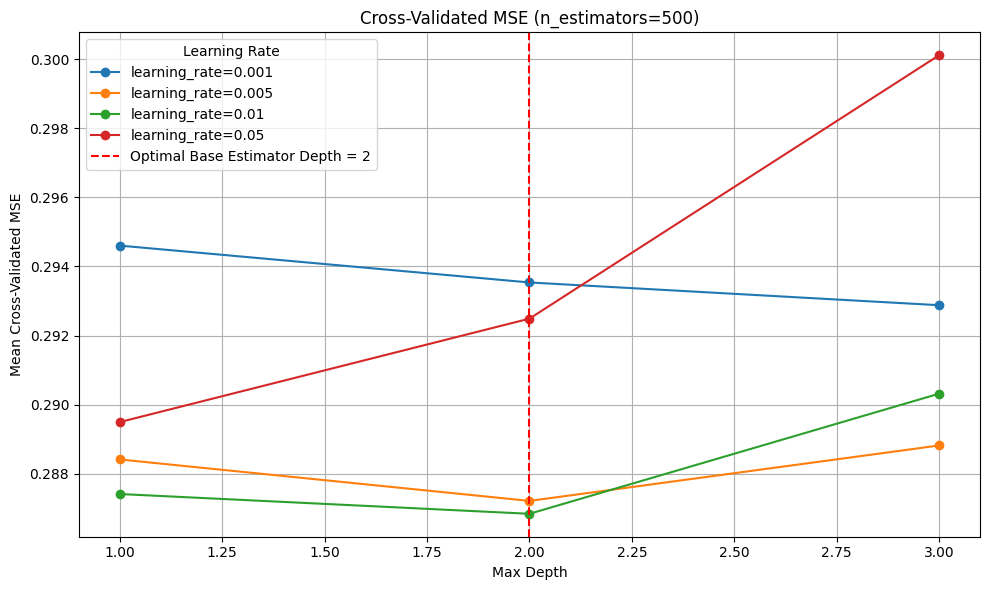

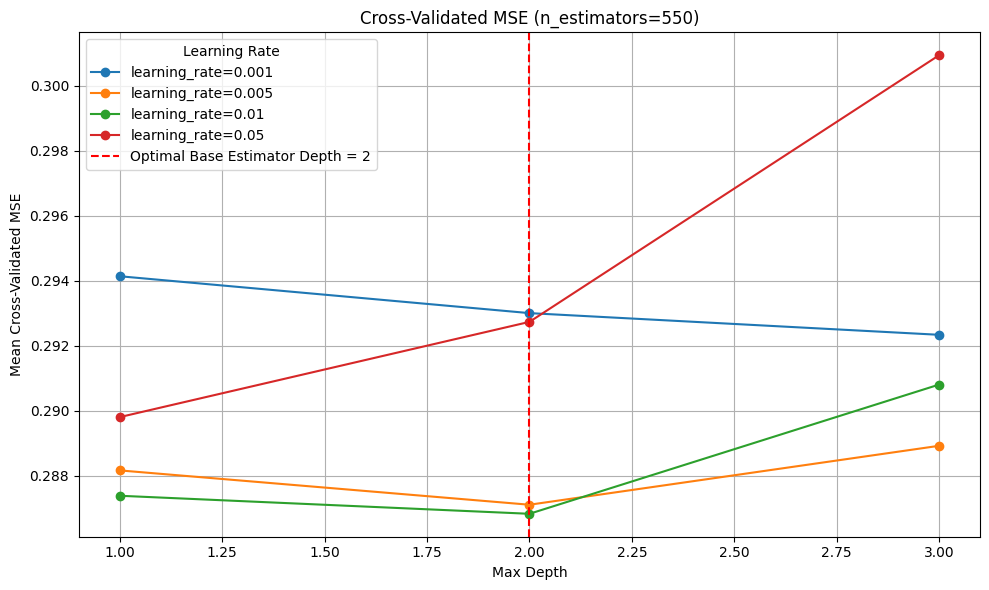

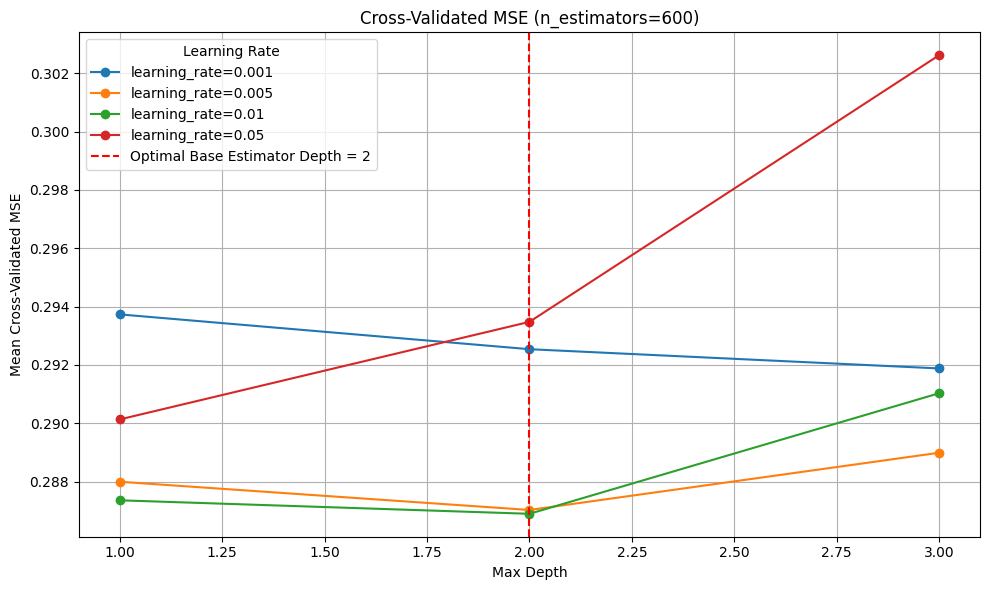

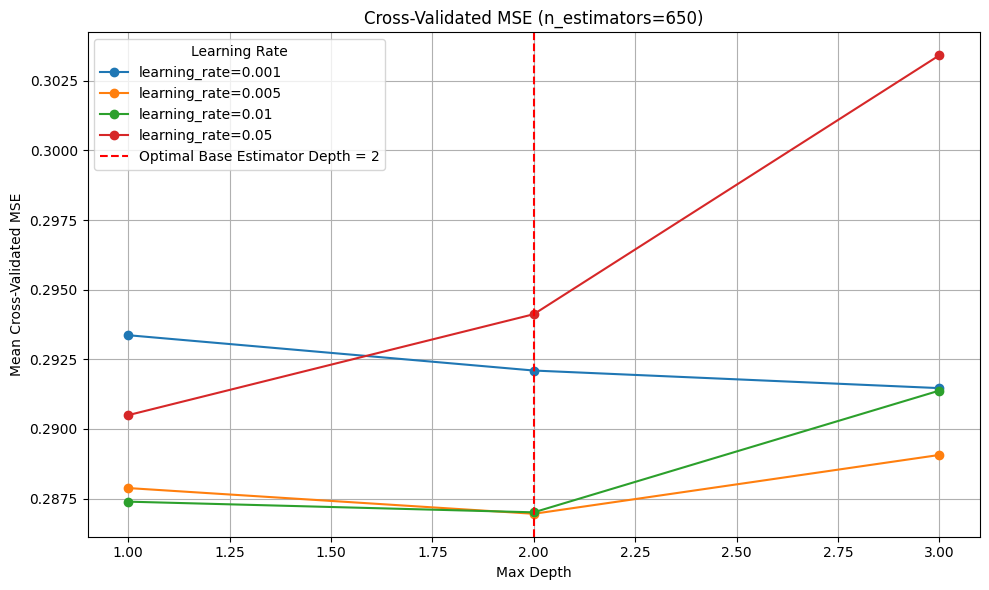

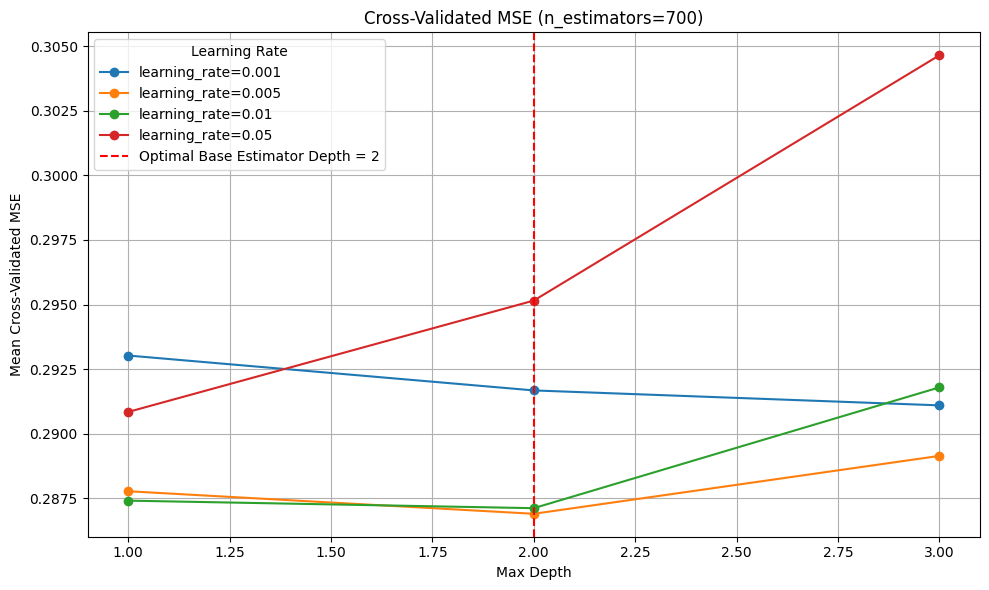

In [ ]:
# Extract the GridSearchCV results into a DataFrame and rename it
boost_cv_results = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive for better interpretation
boost_cv_results['mean_test_mse'] = -boost_cv_results['mean_test_score']

# Ensure parameters are sorted for consistent graphing
boost_cv_results = boost_cv_results.sort_values(by=['param_n_estimators', 'param_max_depth', 'param_learning_rate'])

# Create unique line graphs for each value of n_estimators
n_estimators_values = sorted(boost_cv_results['param_n_estimators'].unique())

for n_estimators in n_estimators_values:
    # Filter results for the current number of iterations
    subset = boost_cv_results[boost_cv_results['param_n_estimators'] == n_estimators]

    # Plot line graphs for mean_test_mse vs max_depth for each learning_rate
    plt.figure(figsize=(10, 6))
    for lr in sorted(subset['param_learning_rate'].unique()):
        lr_subset = subset[subset['param_learning_rate'] == lr]
        plt.plot(
            lr_subset['param_max_depth'],
            lr_subset['mean_test_mse'],
            marker='o',
            label=f"learning_rate={lr}"
        )


    # Add title, labels, legend, and grid
    plt.axvline(x=best_base_depth, color='red', linestyle='--', label=f'Optimal Base Estimator Depth = {best_base_depth}')
    plt.title(f"Cross-Validated MSE (n_estimators={n_estimators})")
    plt.xlabel("Max Depth")
    plt.ylabel("Mean Cross-Validated MSE")
    plt.legend(title="Learning Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Train the final model using the best parameters
final_gb = grid_search.best_estimator_

# Evaluate the final model
y_train_pred = final_gb.predict(X_train)
y_test_pred = final_gb.predict(X_test)

boost_train_mse = mean_squared_error(y_train, y_train_pred)
boost_test_mse = mean_squared_error(y_test, y_test_pred)
boost_test_r2 = r2_score(y_test, y_test_pred)

print(f"Gradient Boosting Train MSE: {boost_train_mse:.4f}")
print(f"Gradient Boosting Test MSE: {boost_test_mse:.4f}")
print(f"Gradient Boosting Test R^2: {boost_test_r2:.4f}")


Gradient Boosting Train MSE: 0.2687
Gradient Boosting Test MSE: 0.3468
Gradient Boosting Test R^2: 0.0089


In [ ]:
# add to model_performances
model_performances.append(
    {
        'model_name': f"Gradient Boosting ({best_n_estimators} iter, base learner depth {best_base_depth}, learning rate {best_lambda})",
        'train_mse': boost_train_mse,
        'test_mse': boost_test_mse,
        'test_rmse': np.sqrt(boost_test_mse),
        'r-squared': boost_test_r2
    }
)

### Feature Importance

Umpire bias is far and away the most important in boosting, followed by some other familiar features of our previous two models (avg plate x, avg balls, home-umpire interaction, etc) as well as some others that were deemed more important via boosting.

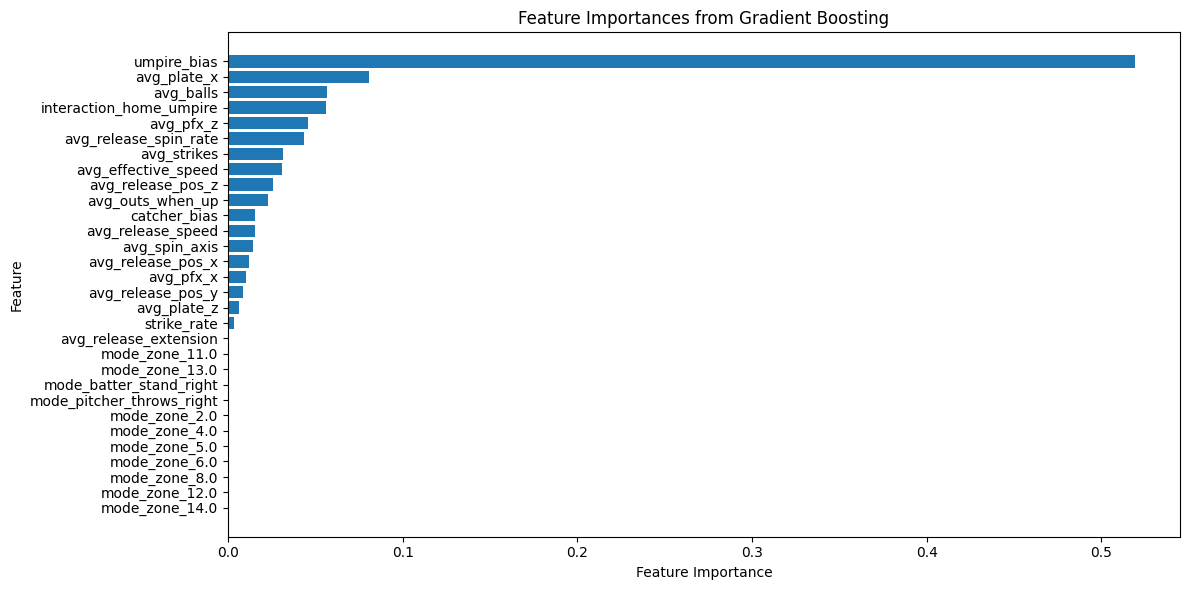

In [ ]:
# Extract feature importances
feature_importances = final_gb.feature_importances_

# Sort feature importances in descending order for better visualization
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Gradient Boosting")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


# 5. Model Results and Conclusion

In [ ]:
model_performance_df = pd.DataFrame(model_performances)

# Set 'model_name' as the index and sort by test MSE
sorted_model_performance_df = model_performance_df.sort_values(by='test_mse', ascending=True)

# Display the styled table
styled_table = sorted_model_performance_df.style.background_gradient(cmap='coolwarm').set_caption("Model Performance Metrics")
display(styled_table)

# Save the styled table to an HTML file
styled_table.to_html("model_performance_table.html")



,model_name,train_mse,test_mse,test_rmse,r-squared
5,"Random Forest (subsets of n/3 features at each split, max depth 40, 250 estimators)",0.037743,0.329090,0.573663,0.059437
4,"Bagging (subtree depth 35, 300 estimators)",0.037888,0.331524,0.575781,0.052481
2,Ridge Regression (Alpha = 0.01),0.282485,0.340598,0.583607,0.026547
1,KNN (67 neighbors),0.286081,0.345100,0.587452,0.013680
6,"Gradient Boosting (550 iter, base learner depth 2, learning rate 0.01)",0.268687,0.346768,0.588870,0.008911
0,Naive Model (arithmetic average),0.303358,0.350131,0.591718,-0.000699
3,Single Regression Tree (Depth = 1),0.288750,0.352695,0.593882,-0.008029


In [ ]:
# finding standard deviation of bias in test set
standard_deviation = y_test.std()

print(f"Standard Deviation of y_test: {standard_deviation}")


Standard Deviation of y_test: 0.5917334645305268


# Conclusion/Discussion


### Models
We deem the best model is Random Forest, as it has the lowest test MSE and the highest R-Squared on unseen data. Thus it likely generalizes the strongest out of all these models. Bagging is a close second.

We are not surprised that these ensemble learning methods are top performers, as they are constructed to be more accurate and more robust to overfitting, better equipped for complex high-dimensional datasets like ours.

What we were surprised by was the relatively weak performance of Gradient Boosting, another ensemble learning method.

### Features
Based on their appearance as top features in our top performing models as well as other models, it appears that umpire bias is the most important feature, followed by statistics such as average balls, outs, and strikes, home-umpire interaction, and pitch position on the plate. Other pitch factors such as spin, speed, and release seem to matter as well.

All of these make sense as top predictors, as umpire bias and the interaction with teams or crowd pressure are likely among the biggest mental factors on an umpire's ability to make calls. Balls, outs, and strikes may sway an umpire to want to end an inning or game for a final batter, or may just add additional pressure in pitch calling which could cause inaccuracy. And pitch metrics such as release speed, spin, and position, of course make sense as these dictate how hard a pitch will be to follow to the naked eye.

### Conclusions
Ideally, the Root Mean Squared Error (RMSE) should be smaller than the standard deviation of the data, as RMSE equal to the standard deviation would be equivalent in performance to the Naive model of averaging. We can see that none of our models improve impressively on this baseline, though most improve slightly, to varying levels of success.

Noticing that our R squared never exceeded 0.06, this means that over 94% of the variation in our response fav_h cannot be explained via our modeling. Hence, it appears that much of the umpire bias effect is in fact random and not due to catcher framing. Even if only 5 or 6% of the bias effect is due to circumstances such catcher framing, though, this could make a difference in the margin.

# Next Steps

If we had more time, we would want to include more data regarding pitchers and individual pitch types. For example, we may imagine that breaking balls are more often miscalled than fastballs, which are easier to view. Our current dataset, despite its scope and size, may not paint a complete picture. Additionally, due to the sheer number of potential features, we may want to spend more time in feature engineering, creating our own set of transformed features to predict from, a lower quantity and higher quality of predictors.